In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ast
import itertools
import seaborn as sns
import os
import glob
import pandas as pd
import os
import re

#### Transaction Delay - builder_censorship_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_builder_censorship_ratio_20250610_100506"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    transactions['experiment'] = f"bcr_{builder_ratio:.3f}"

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
   experiment     sanctioned_type       mean         std
0   bcr_0.000  Non-sanctioned (0)  37.911197  124.084247
1   bcr_0.000      Sanctioned (1)  47.741898  139.324714
2   bcr_0.050  Non-sanctioned (0)  36.702325  120.549170
3   bcr_0.050      Sanctioned (1)  51.963509  176.935176
4   bcr_0.100  Non-sanctioned (0)  20.027214   34.772231
5   bcr_0.100      Sanctioned (1)  31.889816   77.946193
6   bcr_0.200  Non-sanctioned (0)  18.066278   22.132

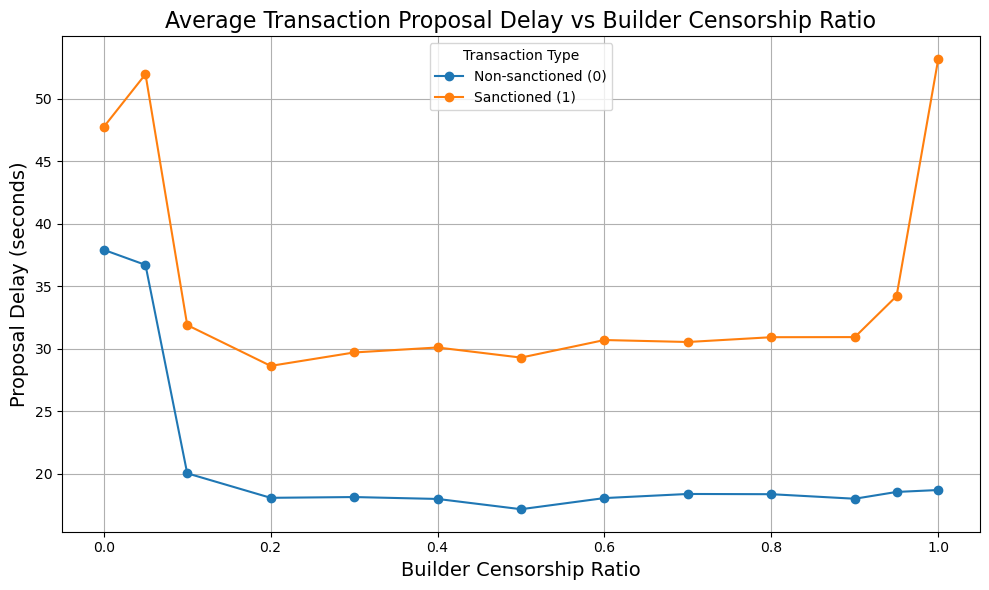

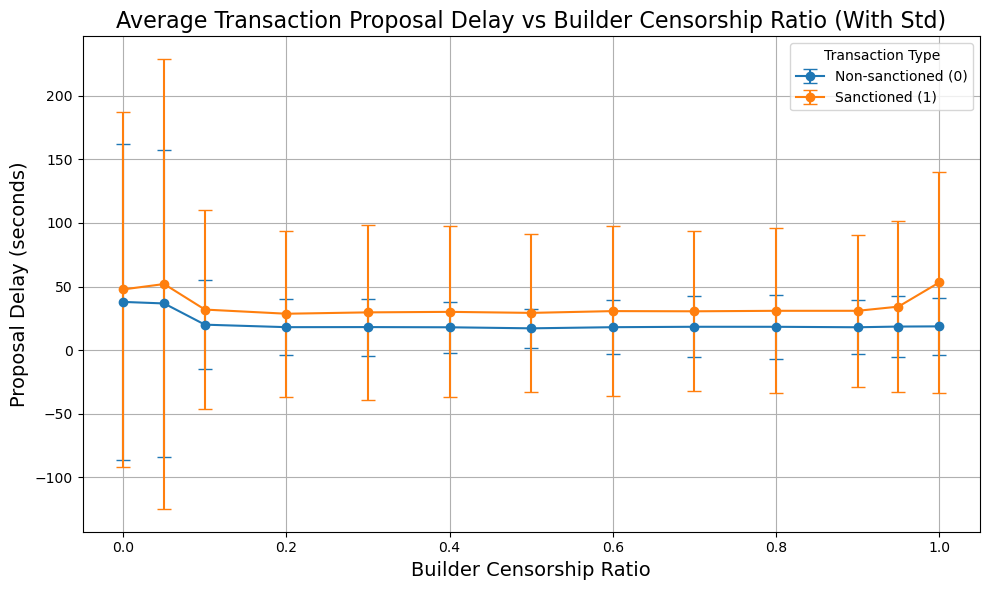

In [ ]:

final_stats['builder_censorship_ratio'] = final_stats['experiment'].str.extract(r'bcr_(\d+\.\d+)').astype(float)


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.plot(group['builder_censorship_ratio'], group['mean'], '-o', label=label)

ax.set_xlabel('Builder Censorship Ratio', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Builder Censorship Ratio', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.errorbar(group['builder_censorship_ratio'], group['mean'], yerr=group['std'],
                fmt='-o', label=label, capsize=5)

ax.set_xlabel('Builder Censorship Ratio', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Builder Censorship Ratio (With Std)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


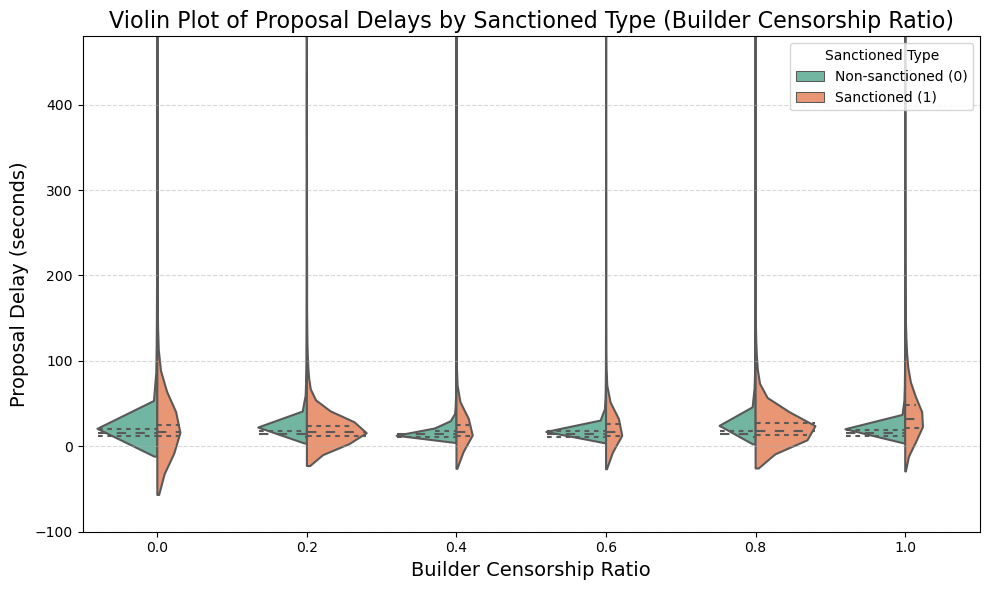

In [ ]:



selected_experiments = ['0.000', '0.200', '0.400', '0.600', '0.800', '1.000']

plt.figure(figsize=(10, 6))


builder_ratio_filtered = combined_transactions[
    combined_transactions['experiment'].str.contains('bcr_') &
    combined_transactions['experiment'].str[-5:].isin(selected_experiments)
]

sns.violinplot(
    data=builder_ratio_filtered,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)


current_labels = plt.gca().get_xticklabels()
new_labels = [f"{float(label.get_text()[-5:]):.1f}" for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.ylim(-100, 480)
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type (Builder Censorship Ratio)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
#### -  builder_censorship_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_builder_censorship_ratio_20250610_100506"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)


results = []

for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()

 
    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks

   
        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })


    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'experiment': f'bcr_{builder_ratio:.3f}',
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: bcr_{builder_ratio:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")



Experiment: bcr_0.000
平均含 sanctioned_type=1 交易的区块数量: 144.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 137.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.32%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.68%
平均空区块数量: 18.600000
空区块占所有已提议区块的比例: 6.20%

Experiment: bcr_0.050
平均含 sanctioned_type=1 交易的区块数量: 143.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 139.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 50.86%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 49.14%
平均空区块数量: 17.200000
空区块占所有已提议区块的比例: 5.73%

Experiment: bcr_0.100
平均含 sanctioned_type=1 交易的区块数量: 144.600000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 153.900000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.44%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.56%
平均空区块数量: 1.500000
空区块占所有已提议区块的比例: 0.50%

Experiment: bcr_0.200
平均含 sanctioned_type=1 交易的区块数量: 143.500000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 155.600000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 47.98%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 52.02%
平均空区块数量: 0.900000
空区块占所有已提议区块的比例: 0.30

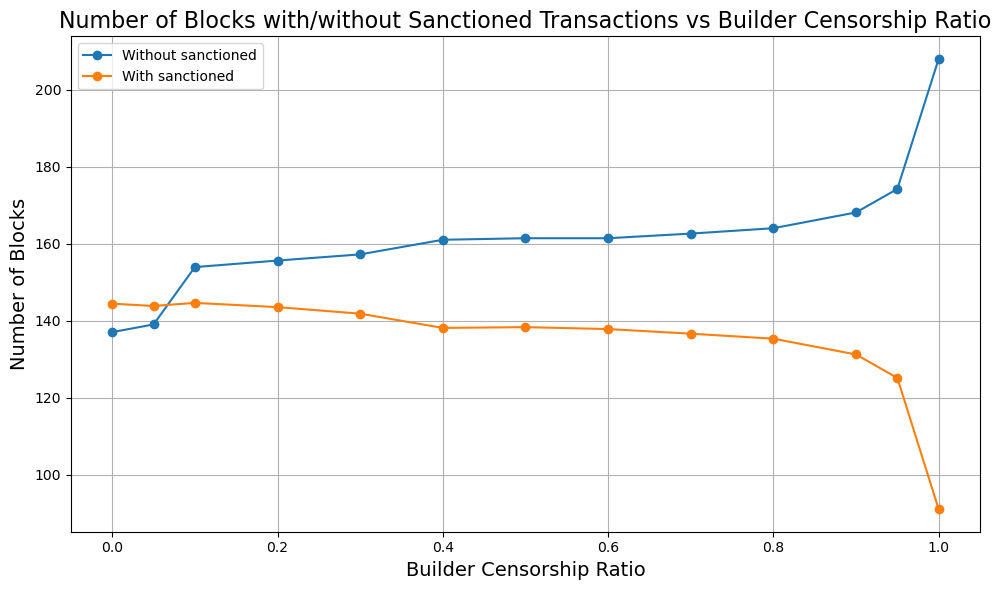

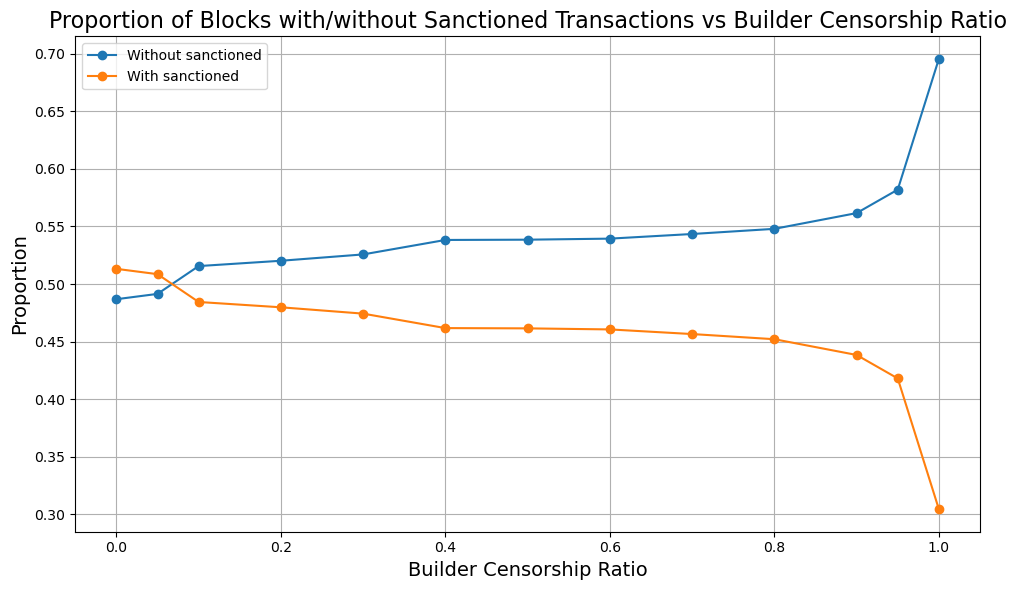

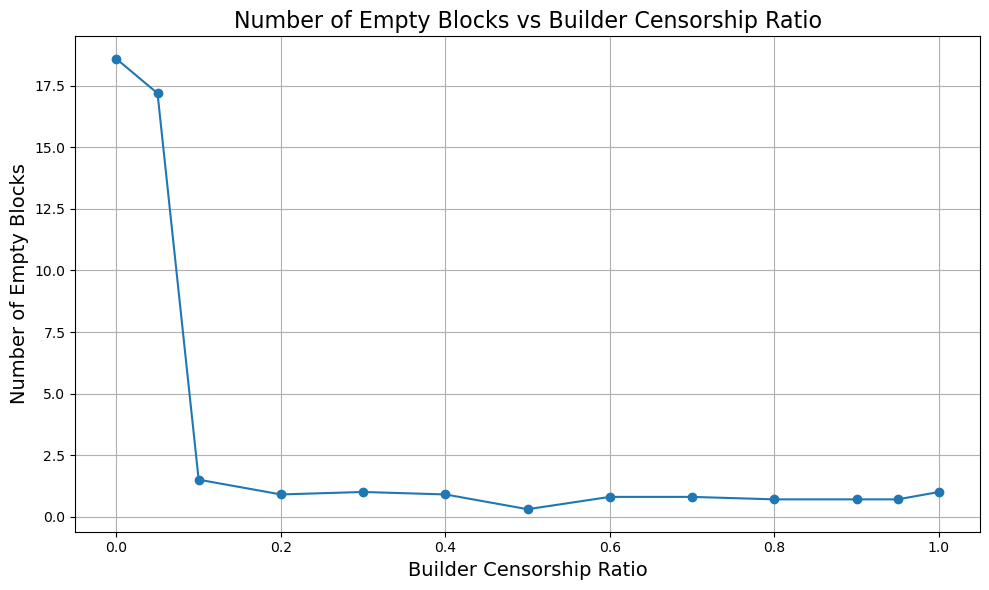

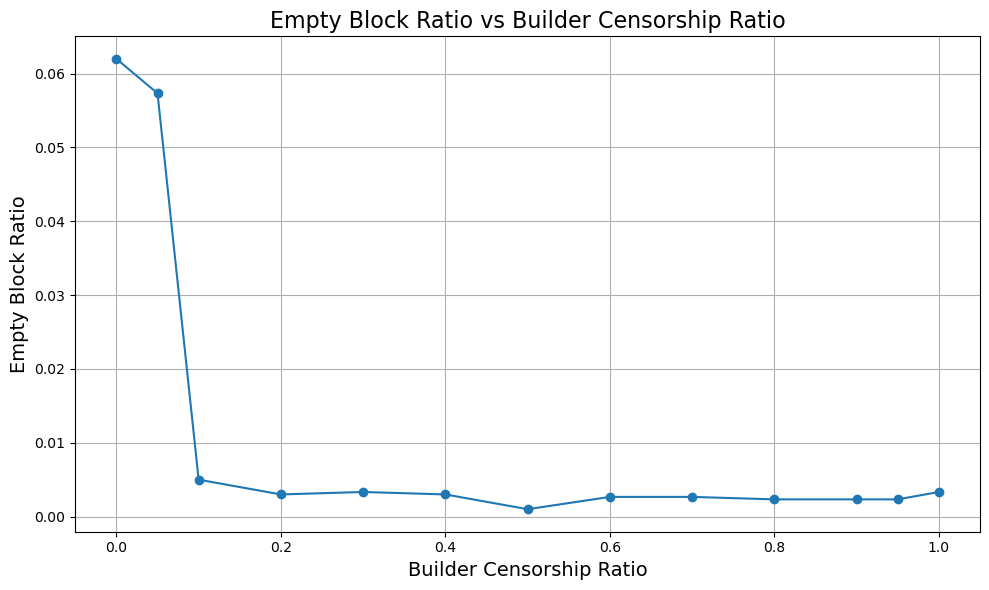

In [ ]:

results_df = pd.DataFrame(results)
results_df['builder_ratio'] = results_df['experiment'].str.extract(r'bcr_(\d+\.\d+)').astype(float)

# Figure 1: Average number of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['avg_blocks_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['builder_ratio'], results_df['avg_blocks_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Number of Blocks', fontsize=14)
plt.title('Number of Blocks with/without Sanctioned Transactions vs Builder Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Proportion of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['ratio_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['builder_ratio'], results_df['ratio_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Proportion of Blocks with/without Sanctioned Transactions vs Builder Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 3: Average number of empty blocks
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['avg_empty_blocks'], marker='o')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Number of Empty Blocks', fontsize=14)
plt.title('Number of Empty Blocks vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 4: Empty block ratio
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['empty_block_ratio'], marker='o')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Empty Block Ratio', fontsize=14)
plt.title('Empty Block Ratio vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### total_block_value，mean_block_value  - builder_censorship_ratio

In [ ]:

# Calculate block value statistics
def calculate_block_value_stats(exp_blocks, builder_ratio):
   
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

    
    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']

    
    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

    
    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'builder_ratio': builder_ratio,
        'avg_total_block_value': avg_total_block_value,
        'avg_mean_block_value': avg_mean_block_value,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }


不同builder_censorship_ratio参数下的总区块价值和平均区块价值:
    builder_ratio  avg_total_block_value  avg_mean_block_value  \
0            0.00           1.185579e+10          4.214063e+07   
1            0.05           1.186498e+10          4.196891e+07   
2            0.10           1.190783e+10          3.989299e+07   
3            0.20           1.190789e+10          3.981290e+07   
4            0.30           1.190728e+10          3.982422e+07   
5            0.40           1.190755e+10          3.981182e+07   
6            0.50           1.190775e+10          3.973251e+07   
7            0.60           1.190831e+10          3.980099e+07   
8            0.70           1.190781e+10          3.979960e+07   
9            0.80           1.190779e+10          3.978632e+07   
10           0.90           1.190756e+10          3.978509e+07   
11           0.95           1.190752e+10          3.978542e+07   
12           1.00           1.190631e+10          3.982081e+07   

    avg_total_block_value_eth  

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


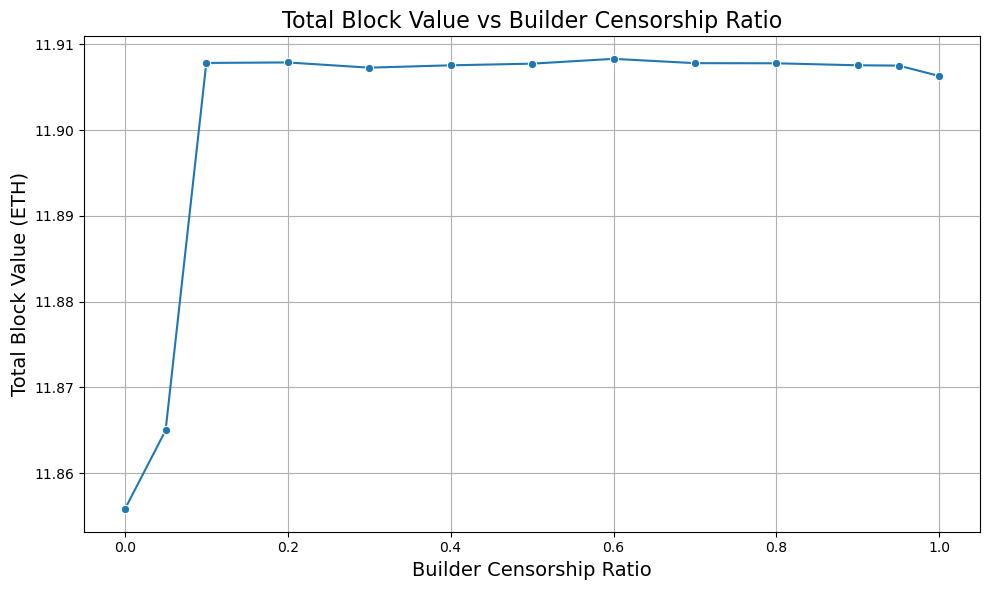

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


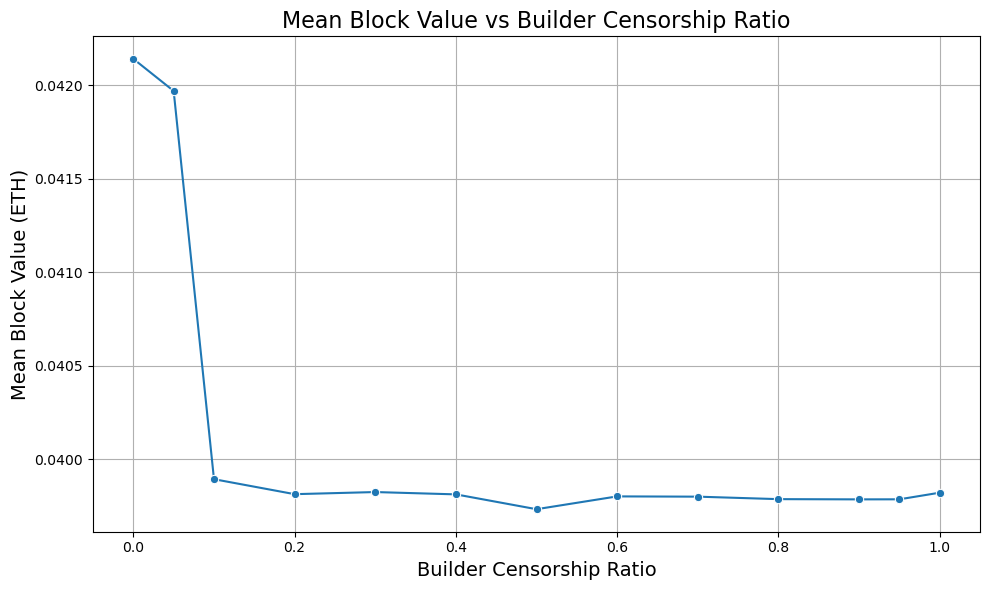

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_builder_censorship_ratio_20250610_100506"


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]
folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_block_value_stats(blocks, builder_ratio)
    results.append(stats)


combined_stats = pd.DataFrame(results)


print("不同builder_censorship_ratio参数下的总区块价值和平均区块价值:")
print(combined_stats.sort_values('builder_ratio'))

# Figure 1: Total Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='avg_total_block_value_eth', marker='o')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.title('Total Block Value vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='avg_mean_block_value_eth', marker='o')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Mean Block Value (ETH)', fontsize=14)
plt.title('Mean Block Value vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for builders under different censorship types  - builder_censorship_ratio

In [ ]:
# Calculate builder profit by policy
def calculate_builder_profit_by_policy(exp_blocks, experiment_name):
    
    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()

    
    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )

   
    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()

    
    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


  builder_policy  mean_builder_profit_per_block(ETH)  \
0            non                            0.002107   
1         strict                            0.000000   
2           weak                            0.000000   
0            non                            0.002117   
1         strict                            0.000000   
2           weak                            0.001795   
0            non                            0.002051   
1         strict                            0.001658   
2           weak                            0.001541   
0            non                            0.002041   
1         strict                            0.001730   
2           weak                            0.001902   
0            non                            0.002040   
1         strict                            0.001751   
2           weak                            0.001997   
0            non                            0.002039   
1         strict                            0.00

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

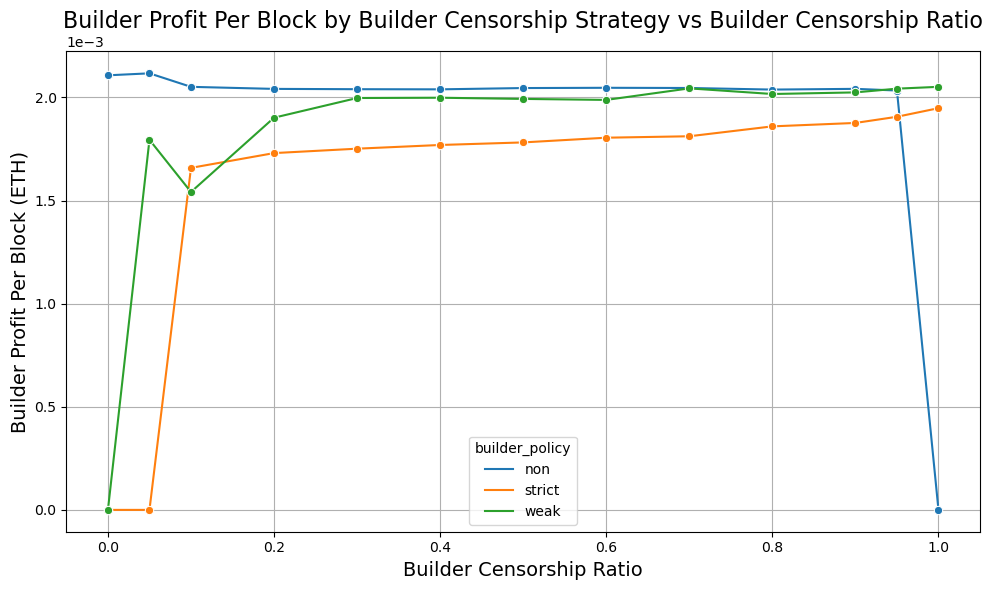

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

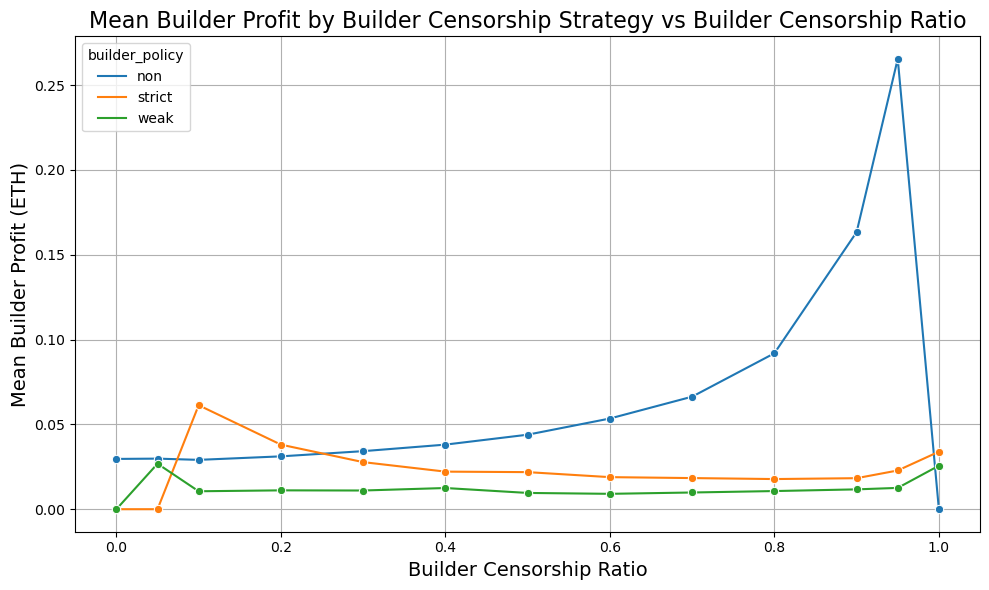

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_builder_censorship_ratio_20250610_100506"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_builder_profit_by_policy(blocks, f'bcr_{builder_ratio:.3f}')
    stats['builder_ratio'] = builder_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['builder_ratio', 'builder_policy']))

# Figure 1: Builder Profit Per Block by Builder Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_builder_profit_per_block(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Builder Profit Per Block (ETH)', fontsize=14)
plt.title('Builder Profit Per Block by Builder Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Builder Profit by Builder Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_builder_profit_per_builder(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Mean Builder Profit (ETH)', fontsize=14)
plt.title('Mean Builder Profit by Builder Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for validators under different censorship types  - builder_censorship_ratio

In [ ]:

# Calculate validator profit by policy

def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]


   proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                            False                              0.041225   
1                             True                              0.032791   
0                            False                              0.041053   
1                             True                              0.032895   
0                            False                              0.039469   
1                             True                              0.031227   
0                            False                              0.039234   
1                             True                              0.031935   
0                            False                              0.039265   
1                             True                              0.031850   
0                            False                              0.039248   
1                             True                              0.031905   
0           

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

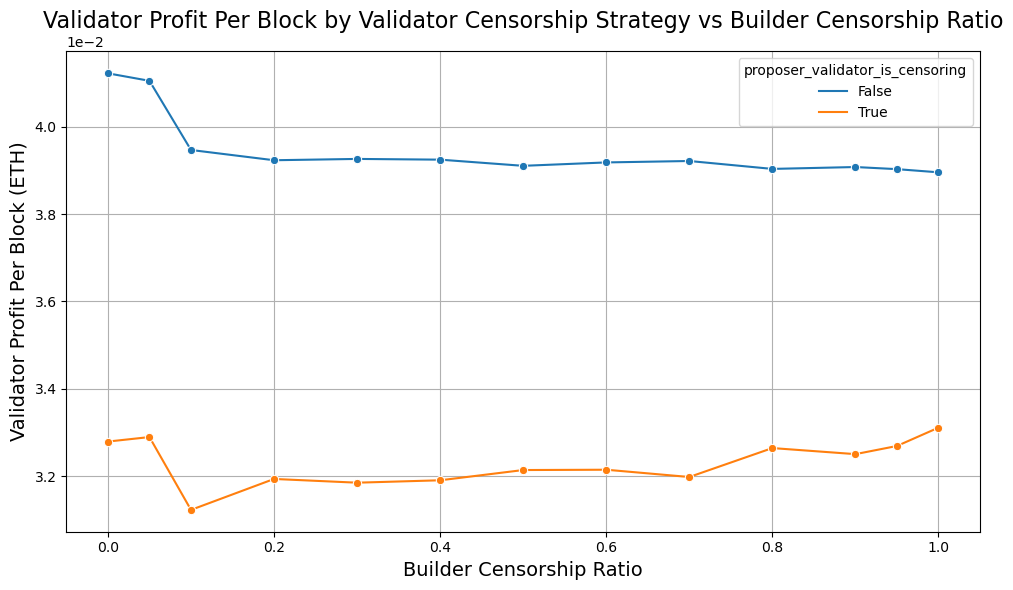

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

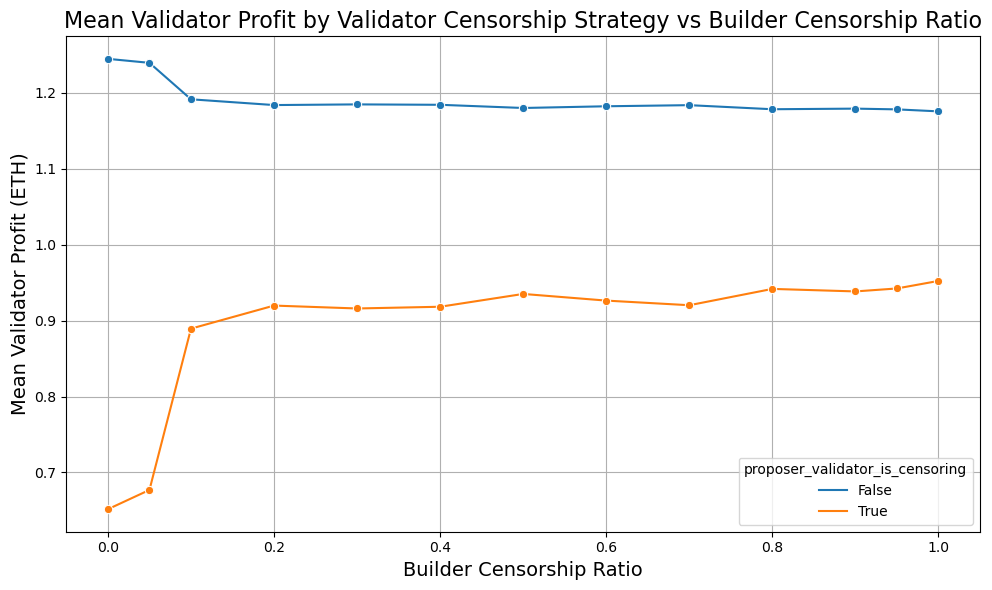

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_builder_censorship_ratio_20250610_100506"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

   
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_validator_profit_by_policy(blocks, f'bcr_{builder_ratio:.3f}')
    stats['builder_ratio'] = builder_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['builder_ratio', 'proposer_validator_is_censoring']))

# Figure 1: Validator Profit Per Block by Validator Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_validator_profit_per_block(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Validator Profit Per Block (ETH)', fontsize=14)
plt.title('Validator Profit Per Block by Validator Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Validator Profit by Validator Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_validator_profit_per_validator(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Builder Censorship Ratio', fontsize=14)
plt.ylabel('Mean Validator Profit (ETH)', fontsize=14)
plt.title('Mean Validator Profit by Validator Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Transaction Delay - strict_builder_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_strict_builder_ratio_20250612_165542"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("strict_builder_ratio_")]


def extract_strict_ratio(folder_name):
    match = re.search(r"strict_builder_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_strict_ratio)


for folder in folders:
    strict_ratio = extract_strict_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    transactions['experiment'] = f"sbr_{strict_ratio:.3f}"

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

[0 rows x 23 columns]

Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
   experiment     sanctioned_type       mean         std
0   sbr_0.000  Non-sanctioned (0)  30.385667   89.356148
1   sbr_0.000      Sanctioned (1)  47.269340  144.408291
2   sbr_0.100  Non-sanctioned (0)  20.300022   39.117487
3   sbr_0.100      Sanctioned (1)  34.630546   88.584949
4   sbr_0.200  Non-sanctioned (0)  19.825926   37.192915
5   sbr_0.200      Sanctioned (1)  32.195096   79.412106
6   sbr_0.300  Non-sanctioned 

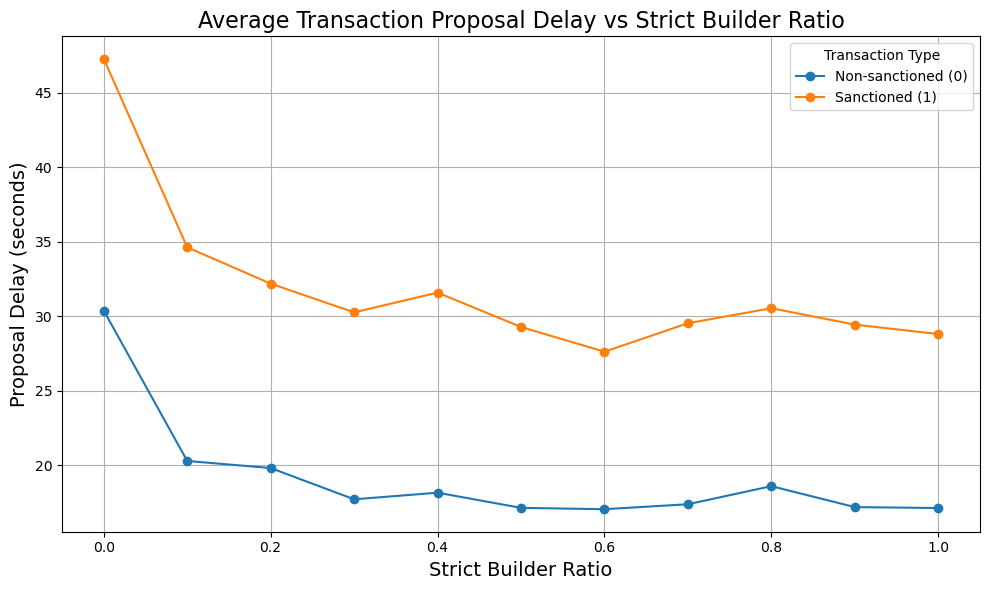

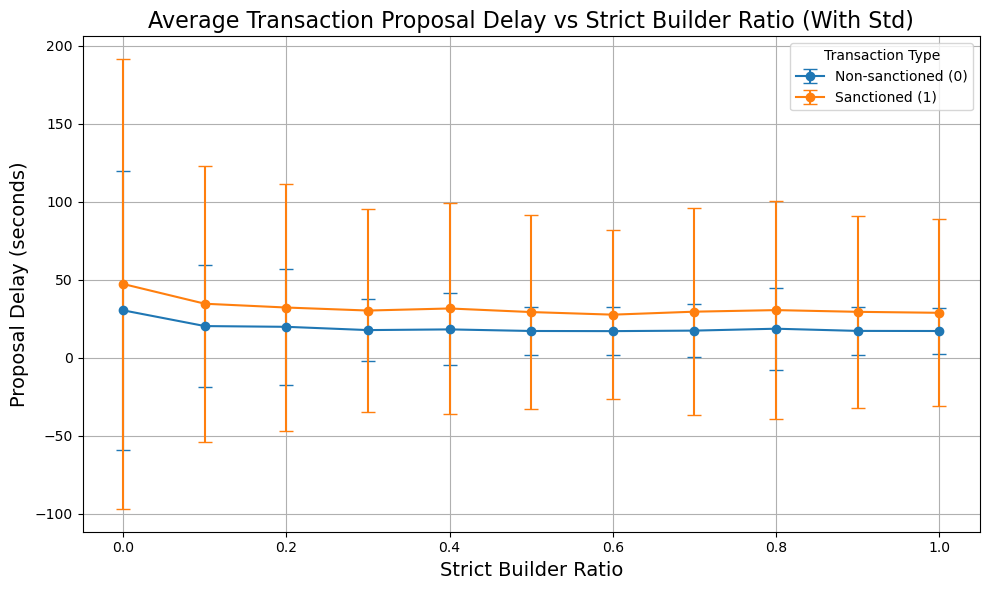

In [ ]:

final_stats['strict_builder_ratio'] = final_stats['experiment'].str.extract(r'sbr_(\d+\.\d+)').astype(float)


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.plot(group['strict_builder_ratio'], group['mean'], '-o', label=label)

ax.set_xlabel('Strict Builder Ratio', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Strict Builder Ratio', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.errorbar(group['strict_builder_ratio'], group['mean'], yerr=group['std'],
                fmt='-o', label=label, capsize=5)

ax.set_xlabel('Strict Builder Ratio', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Strict Builder Ratio (With Std)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


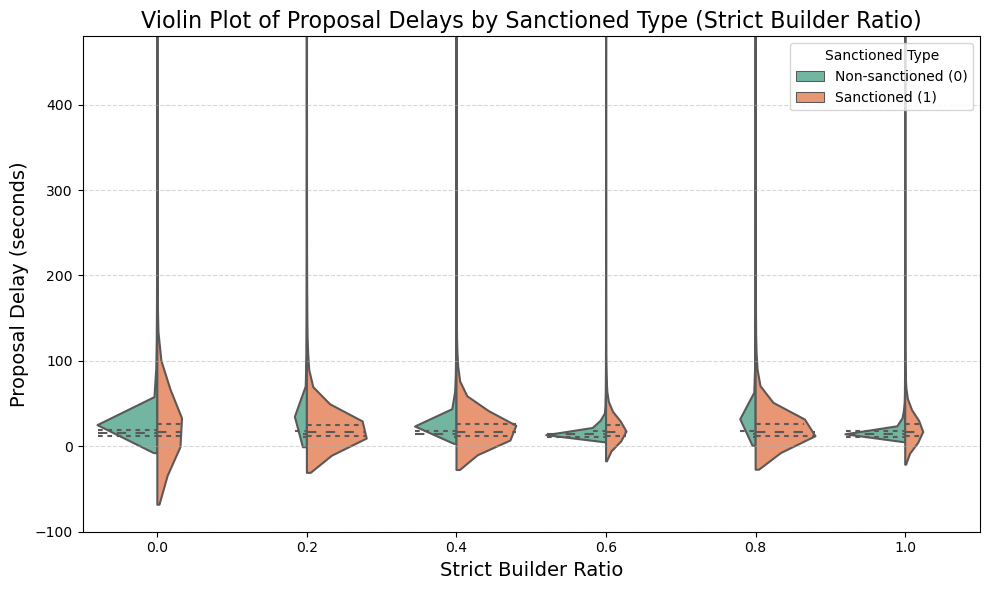

In [ ]:



selected_experiments = ['0.000', '0.200', '0.400', '0.600', '0.800', '1.000']

plt.figure(figsize=(10, 6))


strict_ratio_filtered = combined_transactions[
    combined_transactions['experiment'].str.contains('sbr_') &
    combined_transactions['experiment'].str[-5:].isin(selected_experiments)
]

sns.violinplot(
    data=strict_ratio_filtered,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)


current_labels = plt.gca().get_xticklabels()
new_labels = [f"{float(label.get_text()[-5:]):.1f}" for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.ylim(-100, 480)
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type (Strict Builder Ratio)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
#### -  strict_builder_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_strict_builder_ratio_20250612_165542"


folders = [f for f in os.listdir(base_dir) if f.startswith("strict_builder_ratio_")]


def extract_strict_ratio(folder_name):
    match = re.search(r"strict_builder_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_strict_ratio)


results = []

for folder in folders:
    strict_ratio = extract_strict_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()

   
    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks

        
        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })

   
    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'experiment': f'sbr_{strict_ratio:.3f}',
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: sbr_{strict_ratio:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")



Experiment: sbr_0.000
平均含 sanctioned_type=1 交易的区块数量: 142.500000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 145.300000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 49.53%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 50.47%
平均空区块数量: 12.200000
空区块占所有已提议区块的比例: 4.07%

Experiment: sbr_0.100
平均含 sanctioned_type=1 交易的区块数量: 143.500000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 154.900000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.09%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.91%
平均空区块数量: 1.600000
空区块占所有已提议区块的比例: 0.53%

Experiment: sbr_0.200
平均含 sanctioned_type=1 交易的区块数量: 141.900000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 156.900000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 47.49%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 52.51%
平均空区块数量: 1.200000
空区块占所有已提议区块的比例: 0.40%

Experiment: sbr_0.300
平均含 sanctioned_type=1 交易的区块数量: 139.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 159.800000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 46.66%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 53.34%
平均空区块数量: 0.400000
空区块占所有已提议区块的比例: 0.13%

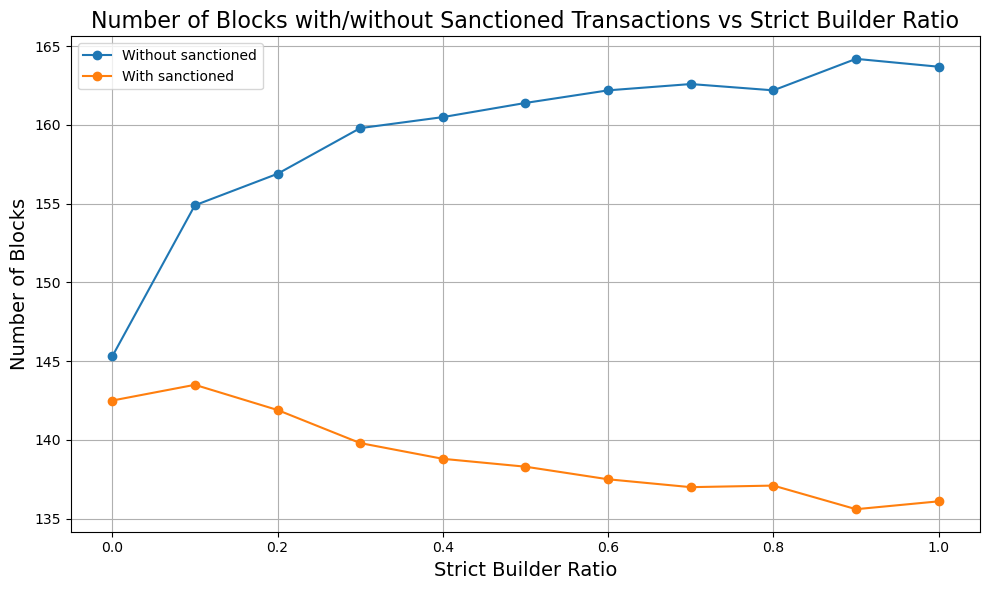

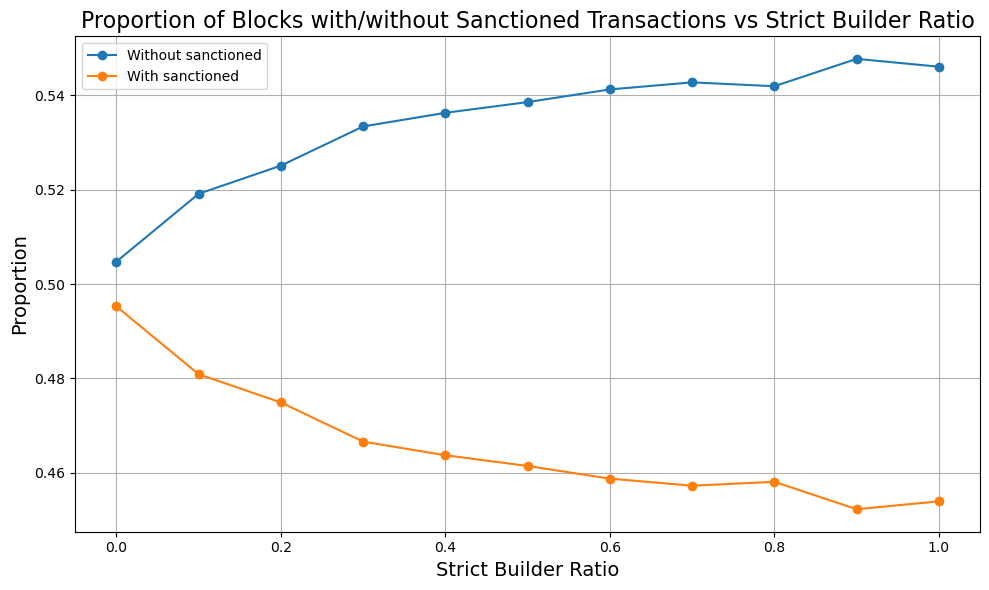

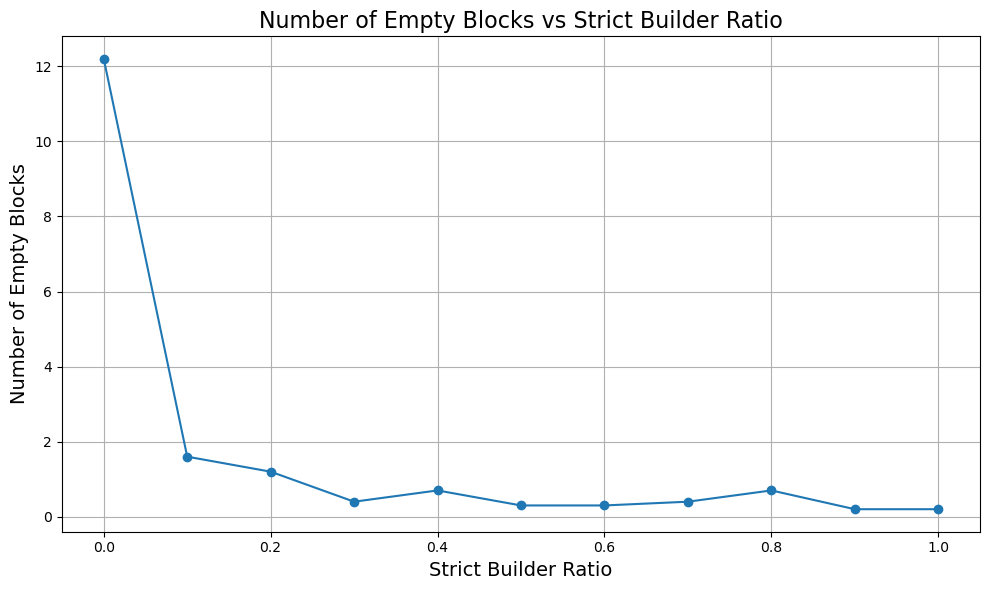

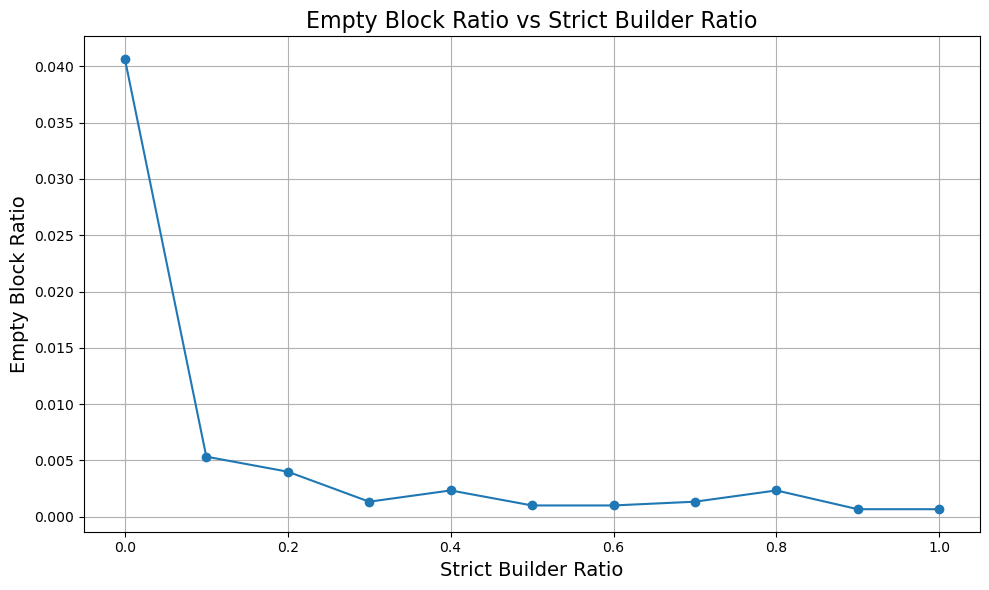

In [ ]:

results_df = pd.DataFrame(results)
results_df['strict_ratio'] = results_df['experiment'].str.extract(r'sbr_(\d+\.\d+)').astype(float)

# Figure 1: Average number of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['strict_ratio'], results_df['avg_blocks_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['strict_ratio'], results_df['avg_blocks_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Number of Blocks', fontsize=14)
plt.title('Number of Blocks with/without Sanctioned Transactions vs Strict Builder Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Proportion of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['strict_ratio'], results_df['ratio_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['strict_ratio'], results_df['ratio_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Proportion of Blocks with/without Sanctioned Transactions vs Strict Builder Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 3: Average number of empty blocks
plt.figure(figsize=(10, 6))
plt.plot(results_df['strict_ratio'], results_df['avg_empty_blocks'], marker='o')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Number of Empty Blocks', fontsize=14)
plt.title('Number of Empty Blocks vs Strict Builder Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 4: Empty block ratio
plt.figure(figsize=(10, 6))
plt.plot(results_df['strict_ratio'], results_df['empty_block_ratio'], marker='o')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Empty Block Ratio', fontsize=14)
plt.title('Empty Block Ratio vs Strict Builder Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### total_block_value，mean_block_value  - strict_builder_ratio

In [ ]:

# Calculate block value statistics
def calculate_block_value_stats(exp_blocks, strict_ratio):
    
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

    
    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']

    
    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

    
    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'strict_ratio': strict_ratio,
        'avg_total_block_value': avg_total_block_value,
        'avg_mean_block_value': avg_mean_block_value,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }


不同strict_builder_ratio参数下的总区块价值和平均区块价值:
    strict_ratio  avg_total_block_value  avg_mean_block_value  \
0            0.0           1.188595e+10          4.130955e+07   
1            0.1           1.190395e+10          3.989390e+07   
2            0.2           1.190766e+10          3.985269e+07   
3            0.3           1.190798e+10          3.974686e+07   
4            0.4           1.190781e+10          3.978628e+07   
5            0.5           1.190775e+10          3.973251e+07   
6            0.6           1.190797e+10          3.973306e+07   
7            0.7           1.190828e+10          3.974755e+07   
8            0.8           1.190811e+10          3.978795e+07   
9            0.9           1.190858e+10          3.972196e+07   
10           1.0           1.190794e+10          3.971982e+07   

    avg_total_block_value_eth  avg_mean_block_value_eth  
0                   11.885947                  0.041310  
1                   11.903953                  0.039894  
2    

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


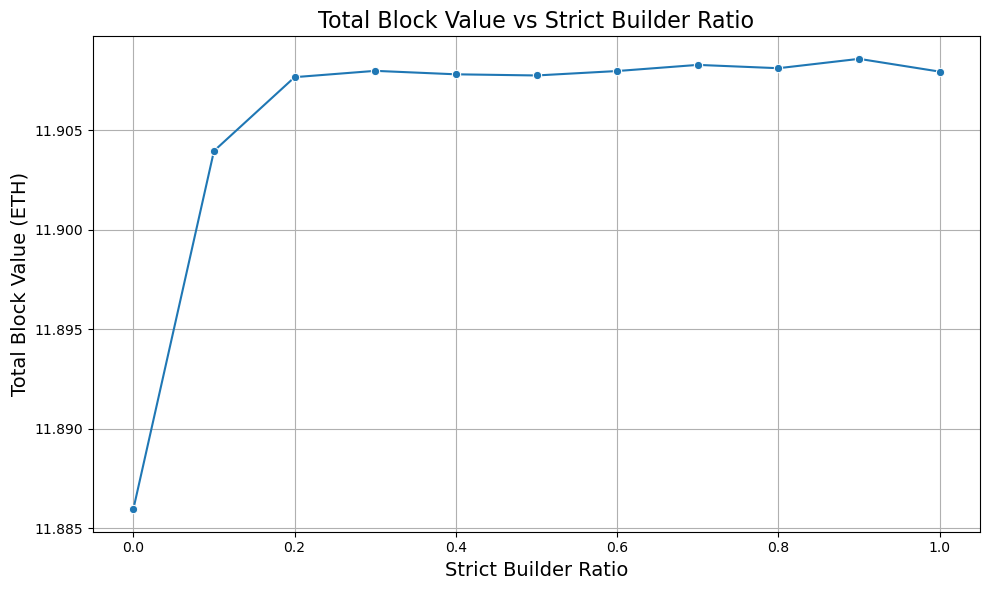

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


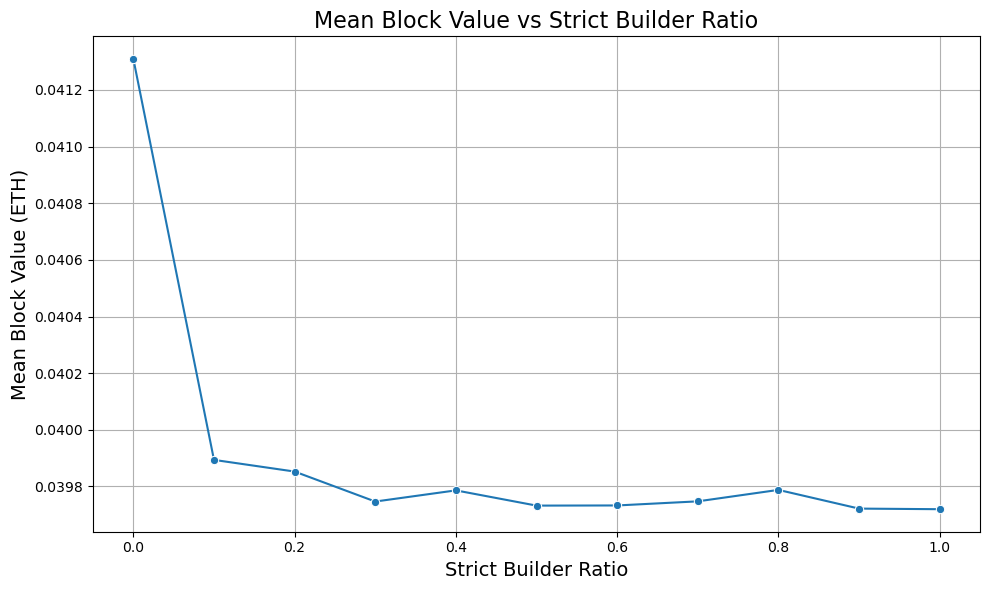

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_strict_builder_ratio_20250612_165542"


def extract_strict_ratio(folder_name):
    match = re.search(r"strict_builder_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("strict_builder_ratio_")]
folders.sort(key=extract_strict_ratio)

results = []


for folder in folders:
    strict_ratio = extract_strict_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_block_value_stats(blocks, strict_ratio)
    results.append(stats)


combined_stats = pd.DataFrame(results)


print("不同strict_builder_ratio参数下的总区块价值和平均区块价值:")
print(combined_stats.sort_values('strict_ratio'))

# Figure 1: Total Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='strict_ratio', y='avg_total_block_value_eth', marker='o')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.title('Total Block Value vs Strict Builder Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='strict_ratio', y='avg_mean_block_value_eth', marker='o')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Mean Block Value (ETH)', fontsize=14)
plt.title('Mean Block Value vs Strict Builder Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for builders under different censorship types  - strict_builder_ratio

In [ ]:
# Calculate builder profit by policy
def calculate_builder_profit_by_policy(exp_blocks, experiment_name):
    
    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()

    
    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )

    
    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()

    
    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


  builder_policy  mean_builder_profit_per_block(ETH)  \
0            non                            0.002100   
1         strict                            0.000000   
2           weak                            0.001921   
0            non                            0.002056   
1         strict                            0.001672   
2           weak                            0.001952   
0            non                            0.002049   
1         strict                            0.001704   
2           weak                            0.001971   
0            non                            0.002042   
1         strict                            0.001759   
2           weak                            0.001982   
0            non                            0.002046   
1         strict                            0.001763   
2           weak                            0.001998   
0            non                            0.002044   
1         strict                            0.00

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

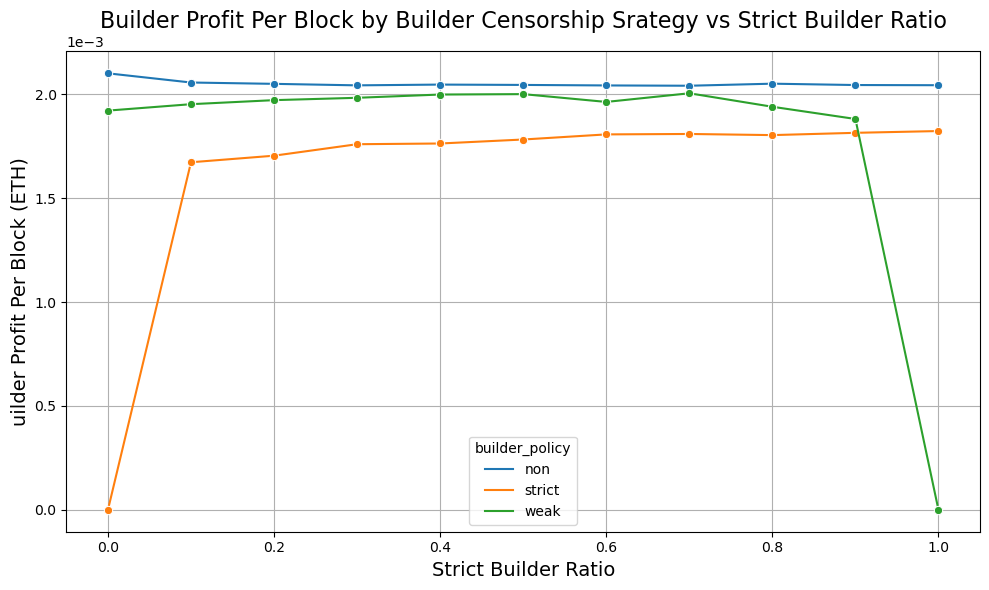

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

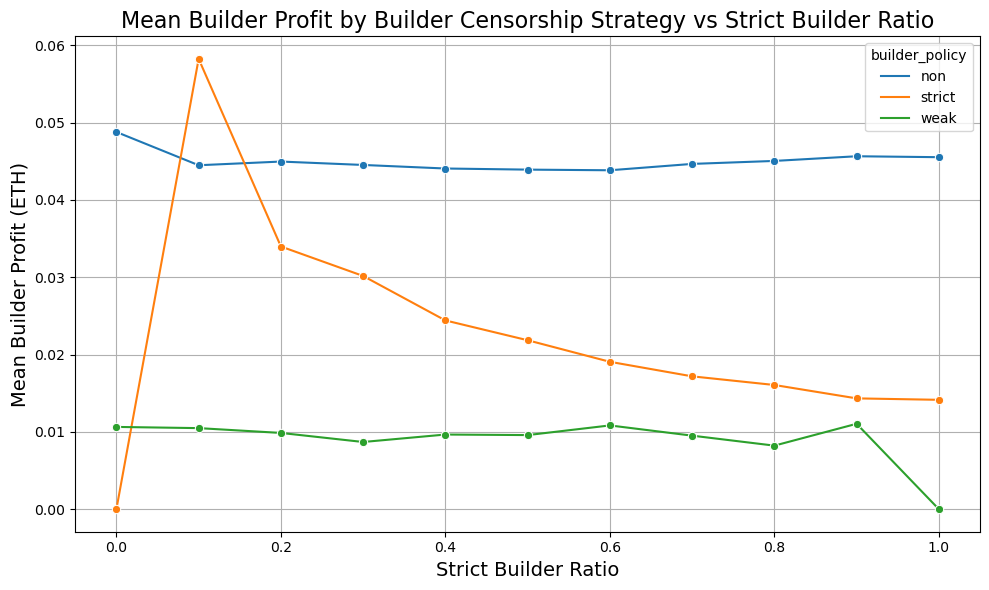

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_strict_builder_ratio_20250612_165542"


folders = [f for f in os.listdir(base_dir) if f.startswith("strict_builder_ratio_")]


def extract_strict_ratio(folder_name):
    match = re.search(r"strict_builder_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_strict_ratio)

results = []


for folder in folders:
    strict_ratio = extract_strict_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_builder_profit_by_policy(blocks, f'sbr_{strict_ratio:.3f}')
    stats['strict_ratio'] = strict_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['strict_ratio', 'builder_policy']))

# Figure 1: Builder Profit Per Block by Builder Censorship Strategy vs Strict Builder Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='strict_ratio', y='mean_builder_profit_per_block(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('uilder Profit Per Block (ETH)', fontsize=14)
plt.title('Builder Profit Per Block by Builder Censorship Srategy vs Strict Builder Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Builder Profit by Builder Censorship Strategy vs Strict Builder Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='strict_ratio', y='mean_builder_profit_per_builder(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Mean Builder Profit (ETH)', fontsize=14)
plt.title('Mean Builder Profit by Builder Censorship Strategy vs Strict Builder Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for validators under different censorship types  - strict_builder_ratio

In [ ]:

# Calculate validator profit by policy

def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]


   proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                            False                              0.040510   
1                             True                              0.032661   
0                            False                              0.039367   
1                             True                              0.031720   
0                            False                              0.039239   
1                             True                              0.032064   
0                            False                              0.039140   
1                             True                              0.032057   
0                            False                              0.039203   
1                             True                              0.031970   
0                            False                              0.039107   
1                             True                              0.032139   
0           

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

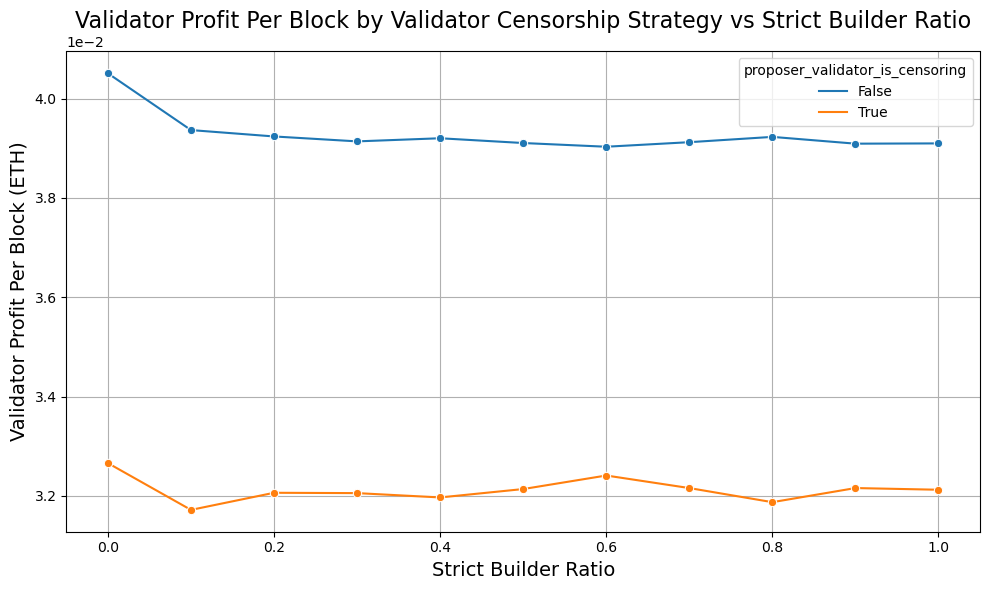

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

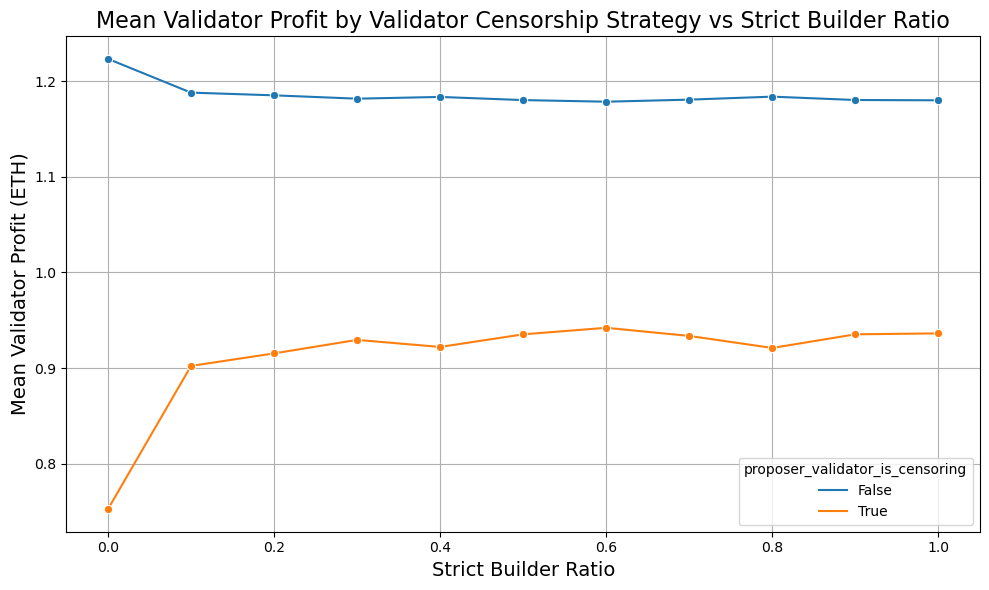

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_strict_builder_ratio_20250612_165542"


folders = [f for f in os.listdir(base_dir) if f.startswith("strict_builder_ratio_")]


def extract_strict_ratio(folder_name):
    match = re.search(r"strict_builder_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_strict_ratio)

results = []



for folder in folders:
    strict_ratio = extract_strict_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_validator_profit_by_policy(blocks, f'sbr_{strict_ratio:.3f}')
    stats['strict_ratio'] = strict_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['strict_ratio', 'proposer_validator_is_censoring']))

# Figure 1: Validator Profit Per Block by Validator Censorship Strategy vs Strict Builder Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='strict_ratio', y='mean_validator_profit_per_block(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Validator Profit Per Block (ETH)', fontsize=14)
plt.title('Validator Profit Per Block by Validator Censorship Strategy vs Strict Builder Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Validator Profit by Validator Censorship Strategy vs Strict Builder Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='strict_ratio', y='mean_validator_profit_per_validator(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Strict Builder Ratio', fontsize=14)
plt.ylabel('Mean Validator Profit (ETH)', fontsize=14)
plt.title('Mean Validator Profit by Validator Censorship Strategy vs Strict Builder Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Transaction Delay - relay_censorship_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_relay_censorship_ratio_20250610_124318"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("relay_censorship_ratio_")]


def extract_relay_ratio(folder_name):
    match = re.search(r"relay_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_relay_ratio)


for folder in folders:
    relay_ratio = extract_relay_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    transactions['experiment'] = f"rcr_{relay_ratio:.3f}"

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

[0 rows x 23 columns]

Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
   experiment     sanctioned_type       mean         std
0   rcr_0.000  Non-sanctioned (0)  15.538033   12.307496
1   rcr_0.000      Sanctioned (1)  17.324358   13.287359
2   rcr_0.100  Non-sanctioned (0)  18.178831   21.223486
3   rcr_0.100      Sanctioned (1)  29.566254   62.124665
4   rcr_0.200  Non-sanctioned (0)  18.940906   28.261006
5   rcr_0.200      Sanctioned (1)  30.385904   68.647127
6   rcr_0.300  Non-sanctioned 

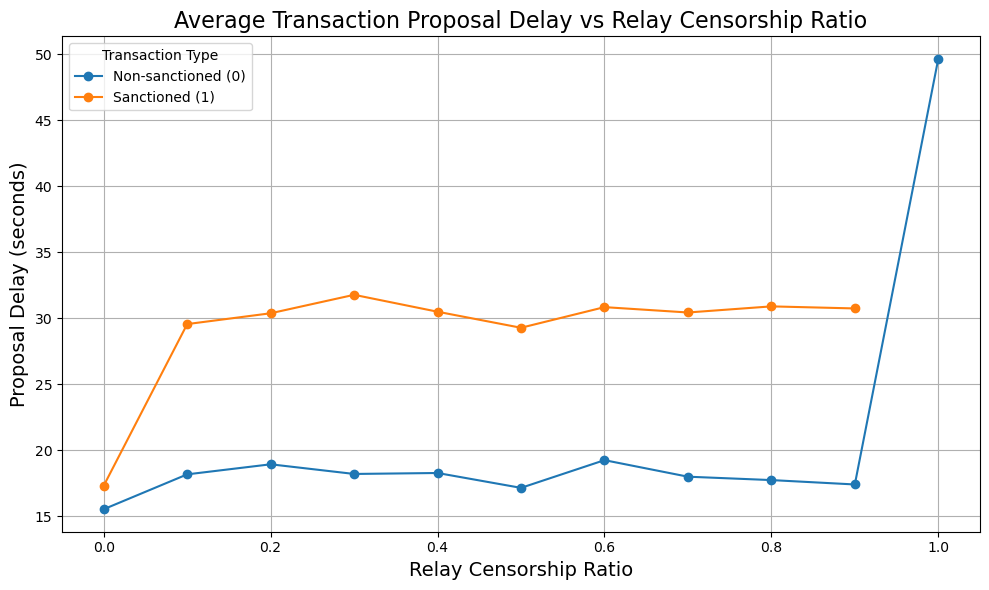

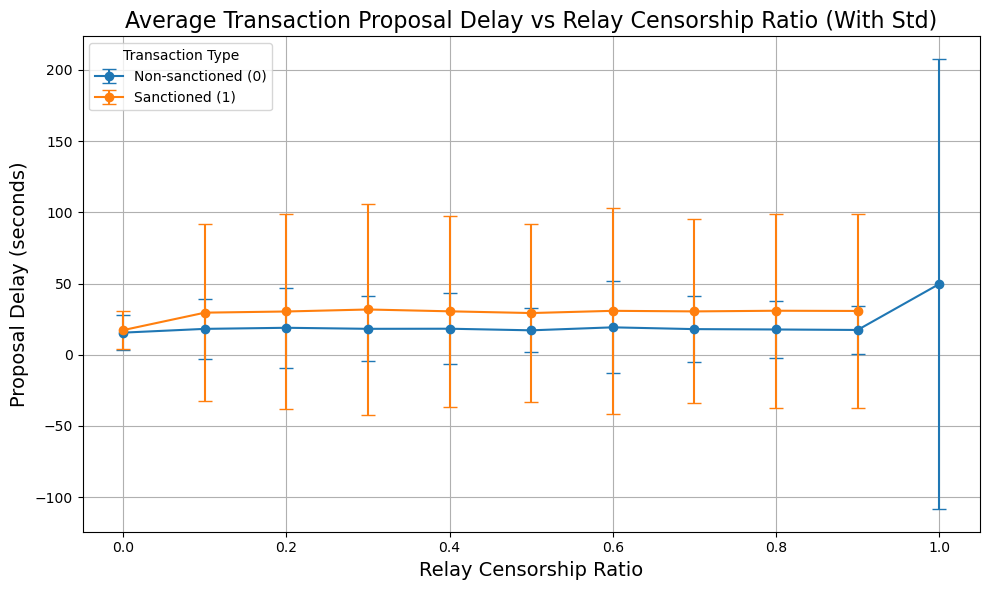

In [ ]:

final_stats['relay_censorship_ratio'] = final_stats['experiment'].str.extract(r'rcr_(\d+\.\d+)').astype(float)


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.plot(group['relay_censorship_ratio'], group['mean'], '-o', label=label)

ax.set_xlabel('Relay Censorship Ratio', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Relay Censorship Ratio', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.errorbar(group['relay_censorship_ratio'], group['mean'], yerr=group['std'],
                fmt='-o', label=label, capsize=5)

ax.set_xlabel('Relay Censorship Ratio', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Relay Censorship Ratio (With Std)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


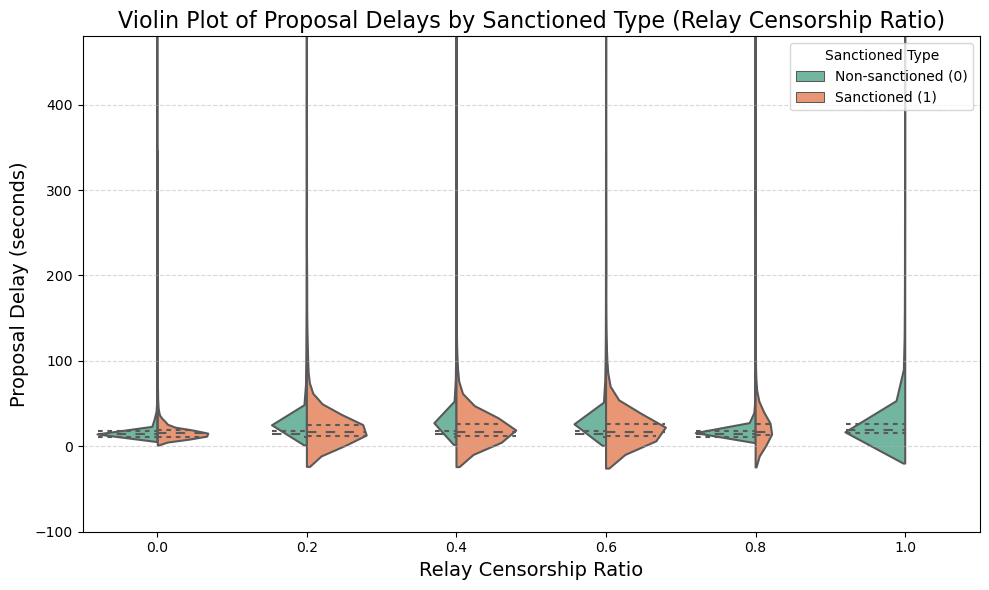

In [ ]:



selected_experiments = ['0.000', '0.200', '0.400', '0.600', '0.800', '1.000']

plt.figure(figsize=(10, 6))


relay_ratio_filtered = combined_transactions[
    combined_transactions['experiment'].str.contains('rcr_') &
    combined_transactions['experiment'].str[-5:].isin(selected_experiments)
]

sns.violinplot(
    data=relay_ratio_filtered,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)


current_labels = plt.gca().get_xticklabels()
new_labels = [f"{float(label.get_text()[-5:]):.1f}" for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.ylim(-100, 480)
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type (Relay Censorship Ratio)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
#### -  relay_censorship_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_relay_censorship_ratio_20250610_124318"


folders = [f for f in os.listdir(base_dir) if f.startswith("relay_censorship_ratio_")]


def extract_relay_ratio(folder_name):
    match = re.search(r"relay_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_relay_ratio)


results = []

for folder in folders:
    relay_ratio = extract_relay_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()


    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks

    
        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })


    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'experiment': f'rcr_{relay_ratio:.3f}',
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: rcr_{relay_ratio:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")



Experiment: rcr_0.000
平均含 sanctioned_type=1 交易的区块数量: 153.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 146.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.30%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.70%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: rcr_0.100
平均含 sanctioned_type=1 交易的区块数量: 139.100000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 160.200000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 46.48%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 53.52%
平均空区块数量: 0.700000
空区块占所有已提议区块的比例: 0.23%

Experiment: rcr_0.200
平均含 sanctioned_type=1 交易的区块数量: 138.600000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 160.500000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 46.34%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 53.66%
平均空区块数量: 0.900000
空区块占所有已提议区块的比例: 0.30%

Experiment: rcr_0.300
平均含 sanctioned_type=1 交易的区块数量: 139.100000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 160.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 46.51%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 53.49%
平均空区块数量: 0.900000
空区块占所有已提议区块的比例: 0.30%


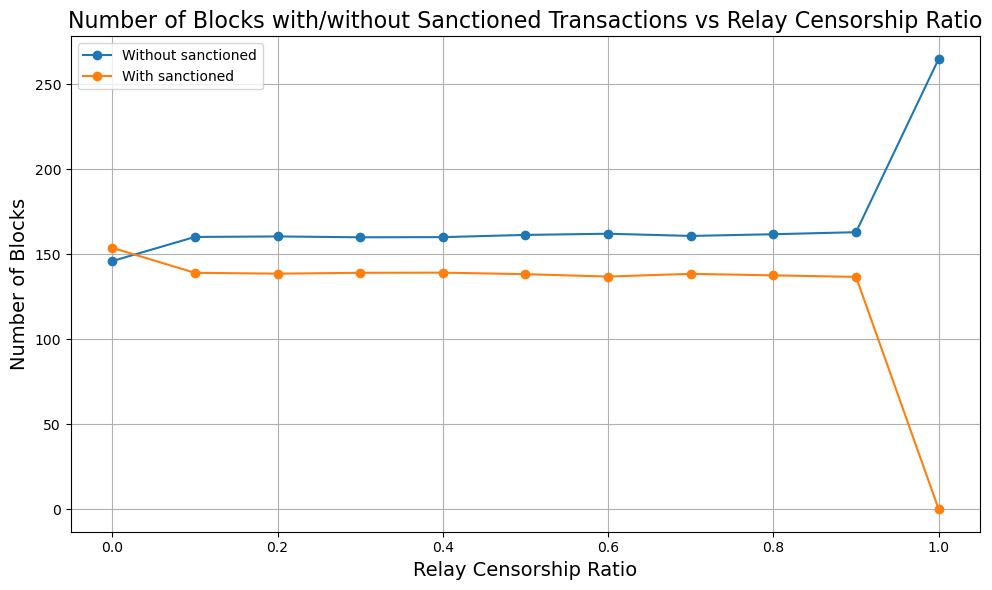

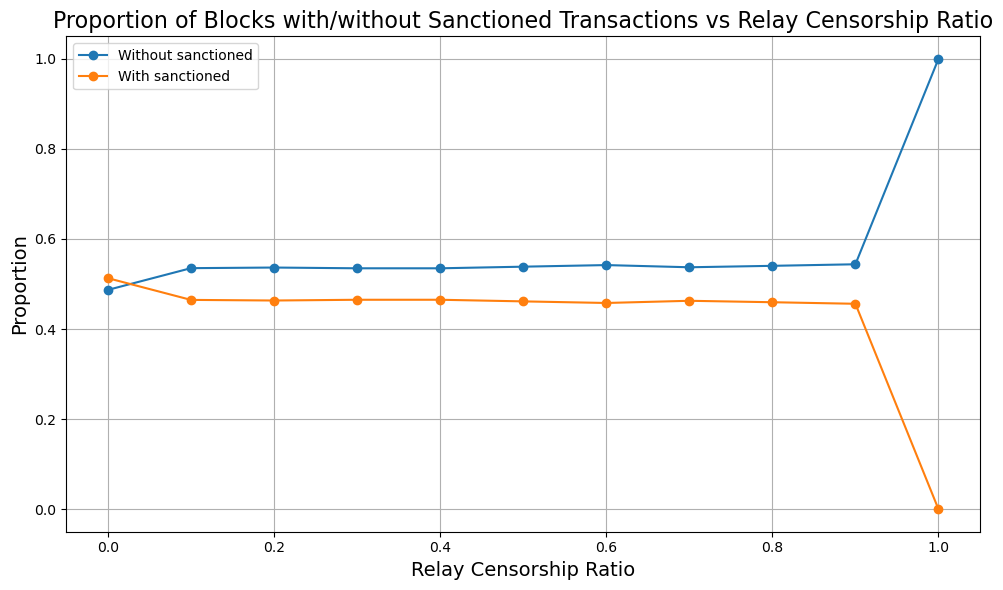

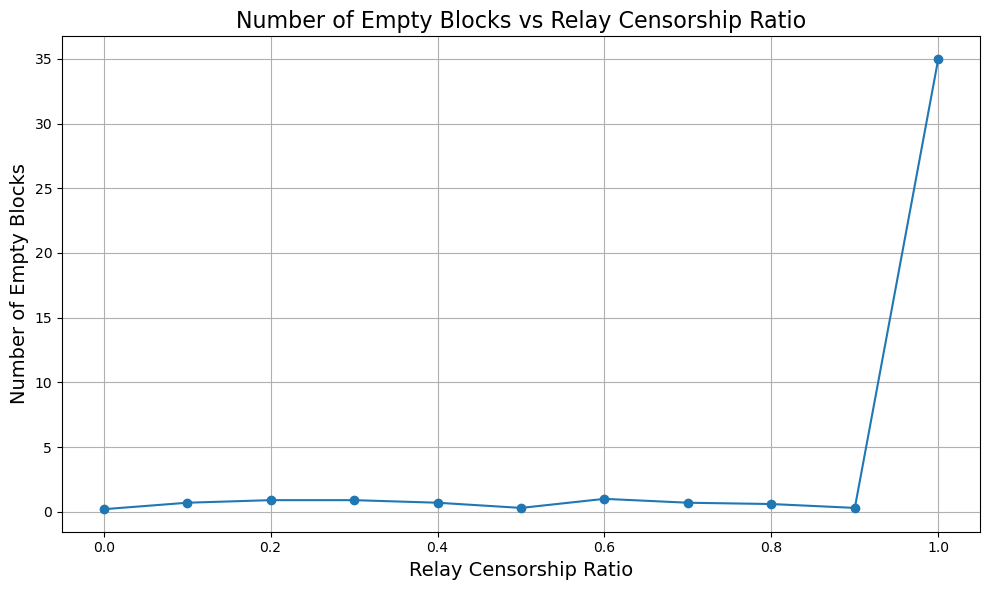

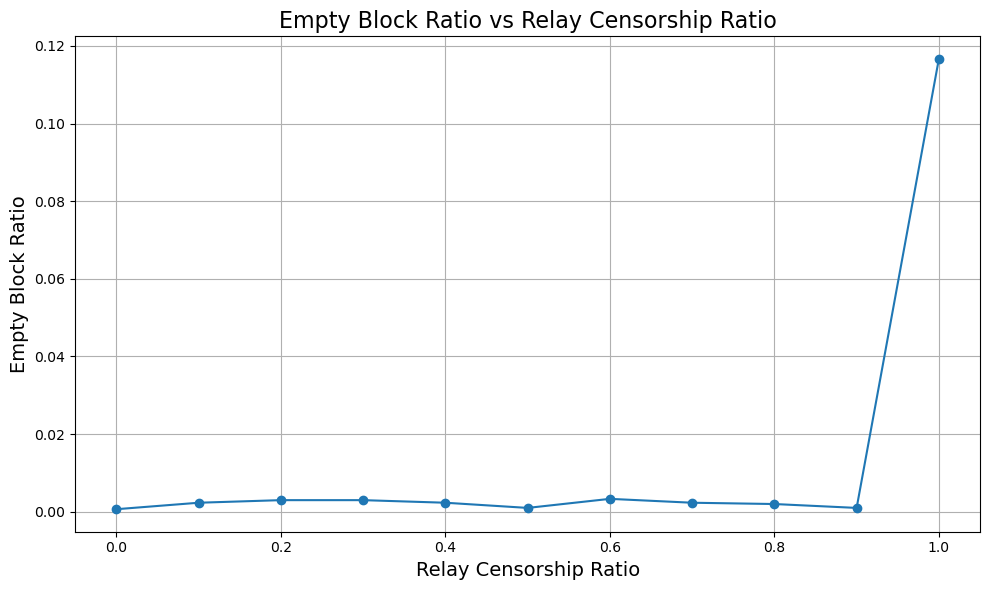

In [ ]:

results_df = pd.DataFrame(results)
results_df['relay_ratio'] = results_df['experiment'].str.extract(r'rcr_(\d+\.\d+)').astype(float)

# Figure 1：Average number of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['relay_ratio'], results_df['avg_blocks_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['relay_ratio'], results_df['avg_blocks_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Number of Blocks', fontsize=14)
plt.title('Number of Blocks with/without Sanctioned Transactions vs Relay Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2：Proportion of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['relay_ratio'], results_df['ratio_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['relay_ratio'], results_df['ratio_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Proportion of Blocks with/without Sanctioned Transactions vs Relay Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 3：Average number of empty blocks
plt.figure(figsize=(10, 6))
plt.plot(results_df['relay_ratio'], results_df['avg_empty_blocks'], marker='o')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Number of Empty Blocks', fontsize=14)
plt.title('Number of Empty Blocks vs Relay Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 4：Empty block ratio
plt.figure(figsize=(10, 6))
plt.plot(results_df['relay_ratio'], results_df['empty_block_ratio'], marker='o')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Empty Block Ratio', fontsize=14)
plt.title('Empty Block Ratio vs Relay Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### total_block_value，mean_block_value  - relay_censorship_ratio

In [ ]:

# Calculate block value statistics
def calculate_block_value_stats(exp_blocks, relay_ratio):
    
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

   
    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']

 
    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

  
    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'relay_ratio': relay_ratio,
        'avg_total_block_value': avg_total_block_value,
        'avg_mean_block_value': avg_mean_block_value,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }


不同relay_censorship_ratio参数下的总区块价值和平均区块价值:
    relay_ratio  avg_total_block_value  avg_mean_block_value  \
0           0.0           1.190923e+10          3.972413e+07   
1           0.1           1.190821e+10          3.978729e+07   
2           0.2           1.190844e+10          3.981482e+07   
3           0.3           1.190845e+10          3.981479e+07   
4           0.4           1.190794e+10          3.978672e+07   
5           0.5           1.190775e+10          3.973251e+07   
6           0.6           1.190796e+10          3.982738e+07   
7           0.7           1.190871e+10          3.978916e+07   
8           0.8           1.190835e+10          3.977443e+07   
9           0.9           1.190796e+10          3.973323e+07   
10          1.0           1.158659e+10          4.381935e+07   

    avg_total_block_value_eth  avg_mean_block_value_eth  
0                   11.909233                  0.039724  
1                   11.908212                  0.039787  
2              

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


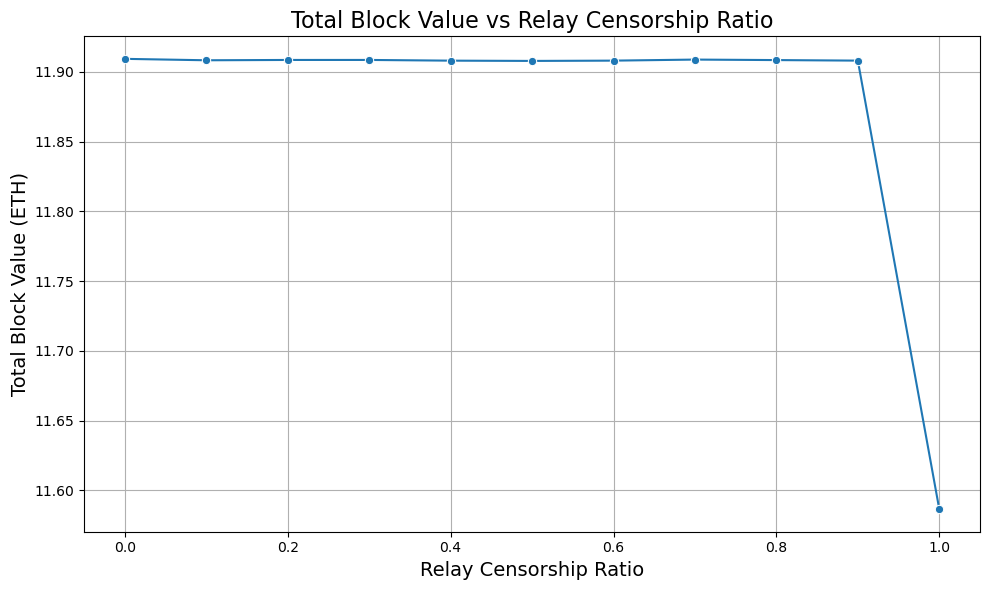

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


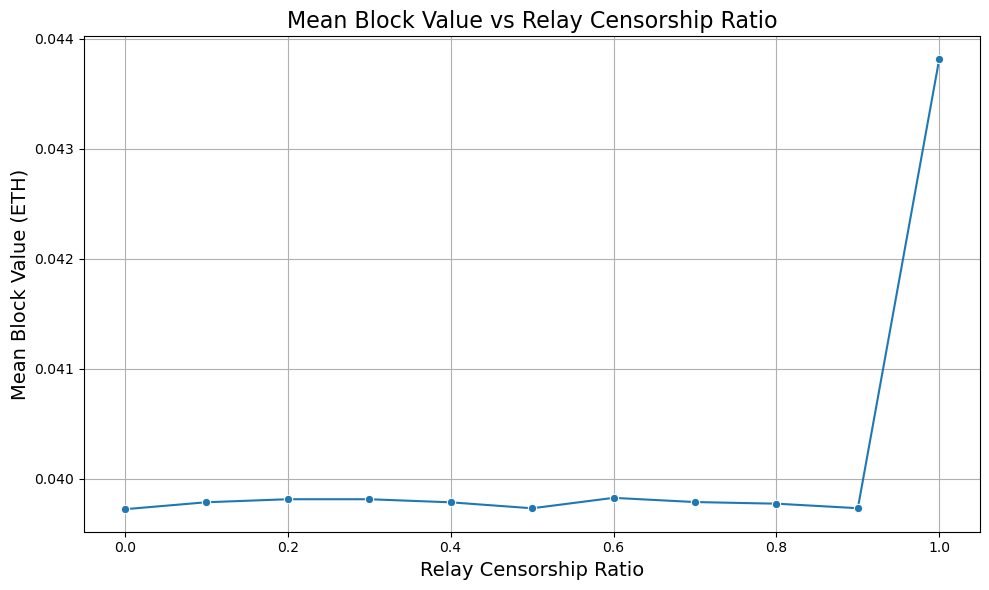

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_relay_censorship_ratio_20250610_124318"


def extract_relay_ratio(folder_name):
    match = re.search(r"relay_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("relay_censorship_ratio_")]
folders.sort(key=extract_relay_ratio)

results = []


for folder in folders:
    relay_ratio = extract_relay_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

   
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

  
    stats = calculate_block_value_stats(blocks, relay_ratio)
    results.append(stats)


combined_stats = pd.DataFrame(results)


print("不同relay_censorship_ratio参数下的总区块价值和平均区块价值:")
print(combined_stats.sort_values('relay_ratio'))

# Figure 1: Total Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_ratio', y='avg_total_block_value_eth', marker='o')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.title('Total Block Value vs Relay Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_ratio', y='avg_mean_block_value_eth', marker='o')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Mean Block Value (ETH)', fontsize=14)
plt.title('Mean Block Value vs Relay Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for builders under different censorship types - relay_censorship_ratio

In [ ]:
# Calculate builder profit by policy
def calculate_builder_profit_by_policy(exp_blocks, experiment_name):
    
    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()

    
    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )

    
    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()

   
    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


  builder_policy  mean_builder_profit_per_block(ETH)  \
0            non                            0.001984   
1         strict                            0.001991   
2           weak                            0.002008   
0            non                            0.002046   
1         strict                            0.001768   
2           weak                            0.001977   
0            non                            0.002045   
1         strict                            0.001782   
2           weak                            0.001970   
0            non                            0.002047   
1         strict                            0.001770   
2           weak                            0.001979   
0            non                            0.002041   
1         strict                            0.001782   
2           weak                            0.002009   
0            non                            0.002044   
1         strict                            0.00

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

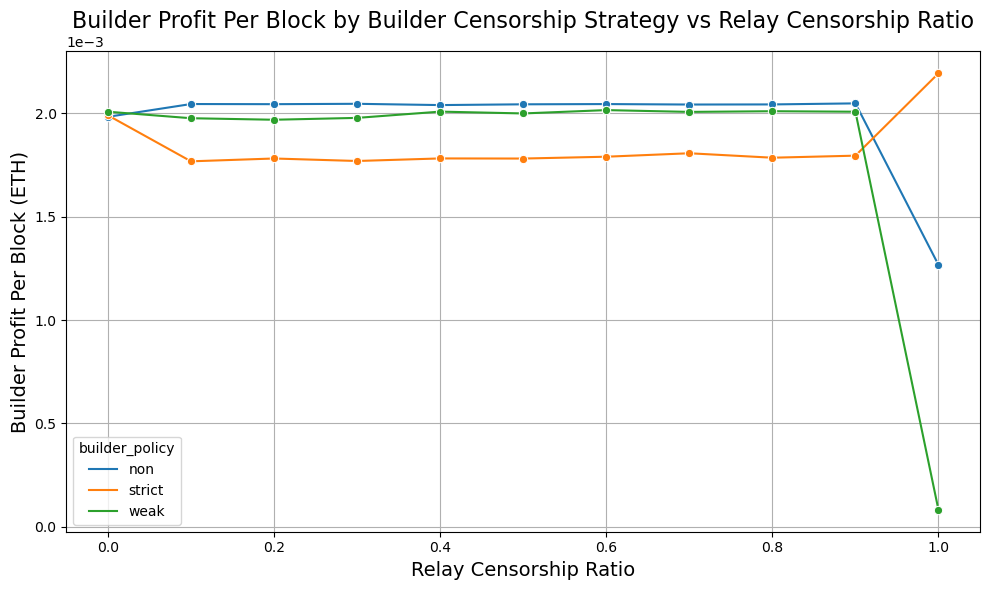

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

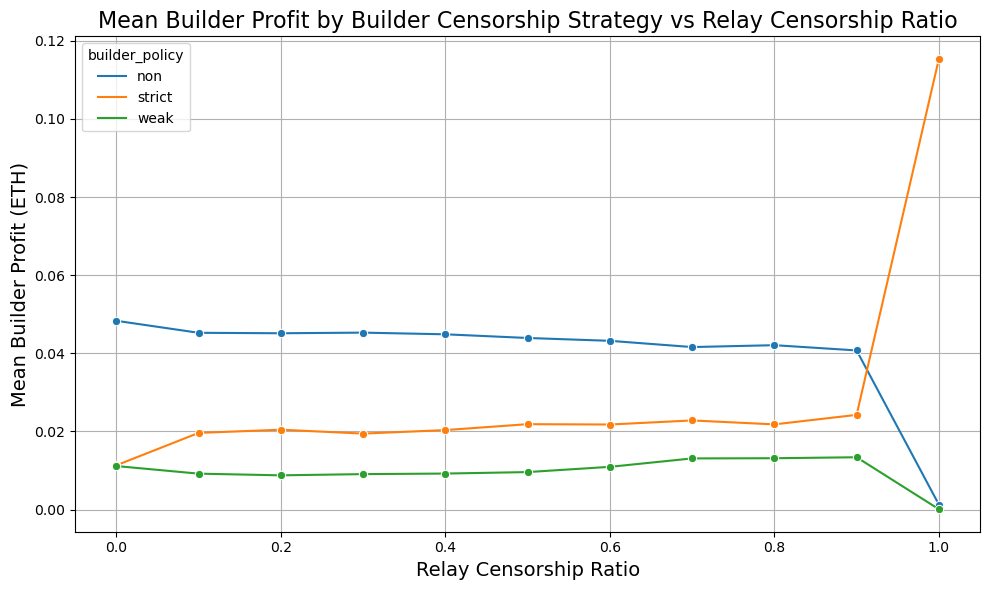

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_relay_censorship_ratio_20250610_124318"


folders = [f for f in os.listdir(base_dir) if f.startswith("relay_censorship_ratio_")]


def extract_relay_ratio(folder_name):
    match = re.search(r"relay_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_relay_ratio)

results = []


for folder in folders:
    relay_ratio = extract_relay_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_builder_profit_by_policy(blocks, f'rcr_{relay_ratio:.3f}')
    stats['relay_ratio'] = relay_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['relay_ratio', 'builder_policy']))

# Figure 1：Builder Profit Per Block by Builder Censorship Strategy vs Relay Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_ratio', y='mean_builder_profit_per_block(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Builder Profit Per Block (ETH)', fontsize=14)
plt.title('Builder Profit Per Block by Builder Censorship Strategy vs Relay Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2：Mean Builder Profit by Builder Censorship Strategy vs Relay Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_ratio', y='mean_builder_profit_per_builder(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Mean Builder Profit (ETH)', fontsize=14)
plt.title('Mean Builder Profit by Builder Censorship Strategy vs Relay Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for validators under different censorship types  - relay_censorship_ratio

In [ ]:

# Calculate validator profit by policy

def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]


   proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                            False                              0.037749   
1                             True                              0.037691   
0                            False                              0.039237   
1                             True                              0.031804   
0                            False                              0.039242   
1                             True                              0.031852   
0                            False                              0.039236   
1                             True                              0.031963   
0                            False                              0.039157   
1                             True                              0.032165   
0                            False                              0.039107   
1                             True                              0.032139   
0           

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

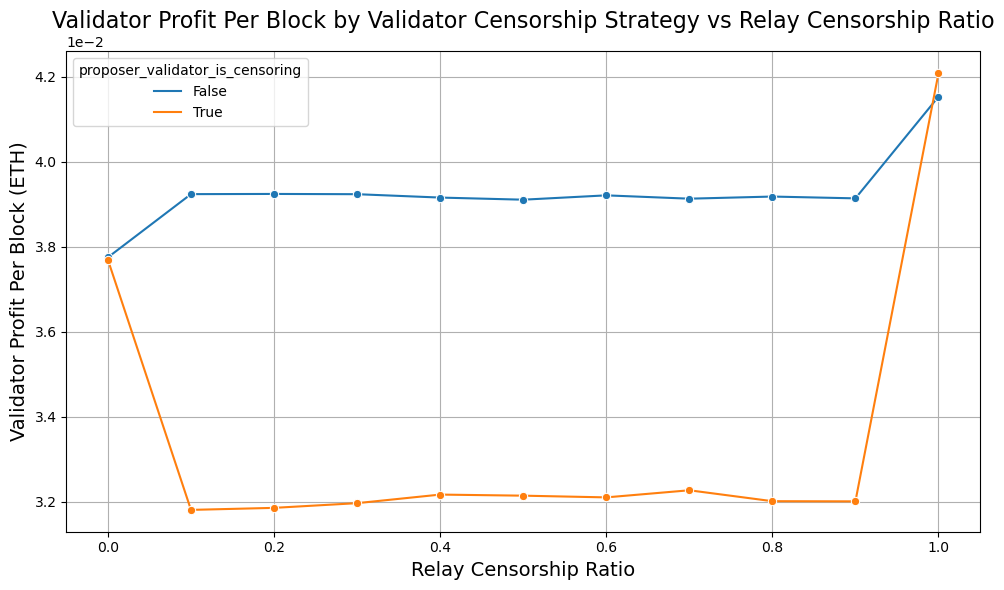

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

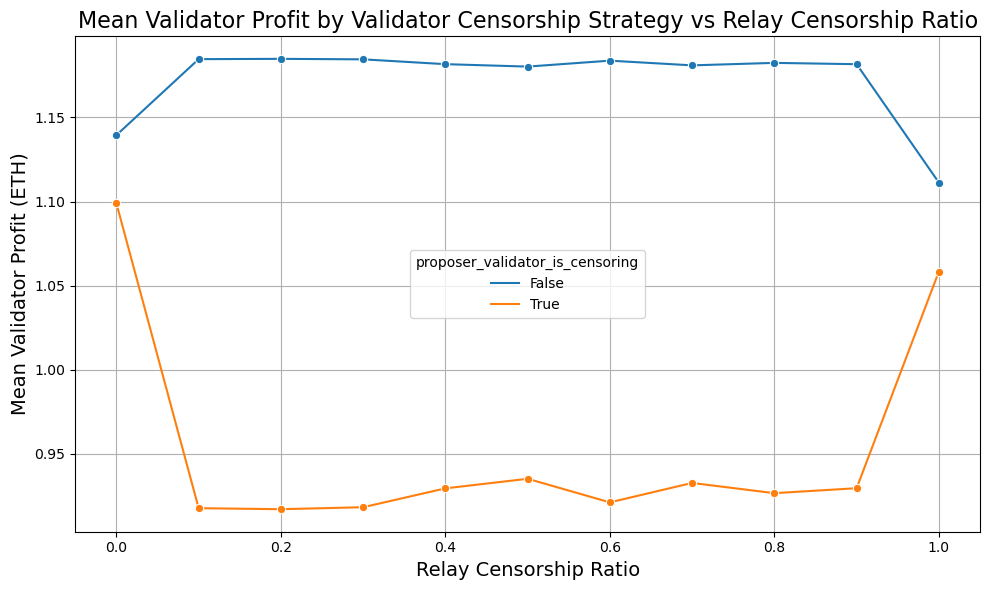

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_relay_censorship_ratio_20250610_124318"


folders = [f for f in os.listdir(base_dir) if f.startswith("relay_censorship_ratio_")]


def extract_relay_ratio(folder_name):
    match = re.search(r"relay_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_relay_ratio)

results = []


for folder in folders:
    relay_ratio = extract_relay_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_validator_profit_by_policy(blocks, f'bcr_{relay_ratio:.3f}')
    stats['relay_ratio'] = relay_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['relay_ratio', 'proposer_validator_is_censoring']))

# Figure 1：Validator Profit Per Block by Validator Censorship Strategy vs Relay Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_ratio', y='mean_validator_profit_per_block(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Validator Profit Per Block (ETH)', fontsize=14)
plt.title('Validator Profit Per Block by Validator Censorship Strategy vs Relay Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2：Mean Validator Profit by Validator Censorship Strategy vs Relay Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='relay_ratio', y='mean_validator_profit_per_validator(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Relay Censorship Ratio', fontsize=14)
plt.ylabel('Mean Validator Profit (ETH)', fontsize=14)
plt.title('Mean Validator Profit by Validator Censorship Strategy vs Relay Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Transaction Delay - validator_censorship_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_validator_censorship_ratio_20250612_103135"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("validator_censorship_ratio_")]


def extract_validator_ratio(folder_name):
    match = re.search(r"validator_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_validator_ratio)


for folder in folders:
    validator_ratio = extract_validator_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    transactions['experiment'] = f"vcr_{validator_ratio:.3f}"

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

[0 rows x 23 columns]

Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
   experiment     sanctioned_type        mean         std
0   vcr_0.000  Non-sanctioned (0)   15.539819   12.173863
1   vcr_0.000      Sanctioned (1)   16.938918   12.693622
2   vcr_0.100  Non-sanctioned (0)   16.419994   14.268875
3   vcr_0.100      Sanctioned (1)   21.845506   32.857034
4   vcr_0.200  Non-sanctioned (0)   17.155240   15.481839
5   vcr_0.200      Sanctioned (1)   29.286784   62.228970
6   vcr_0.300  Non-sanc

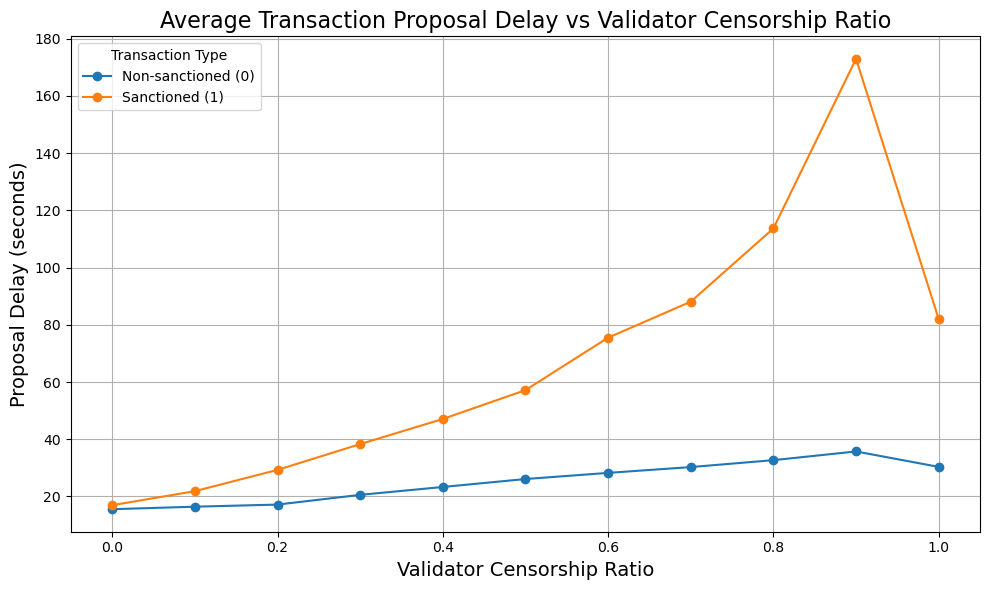

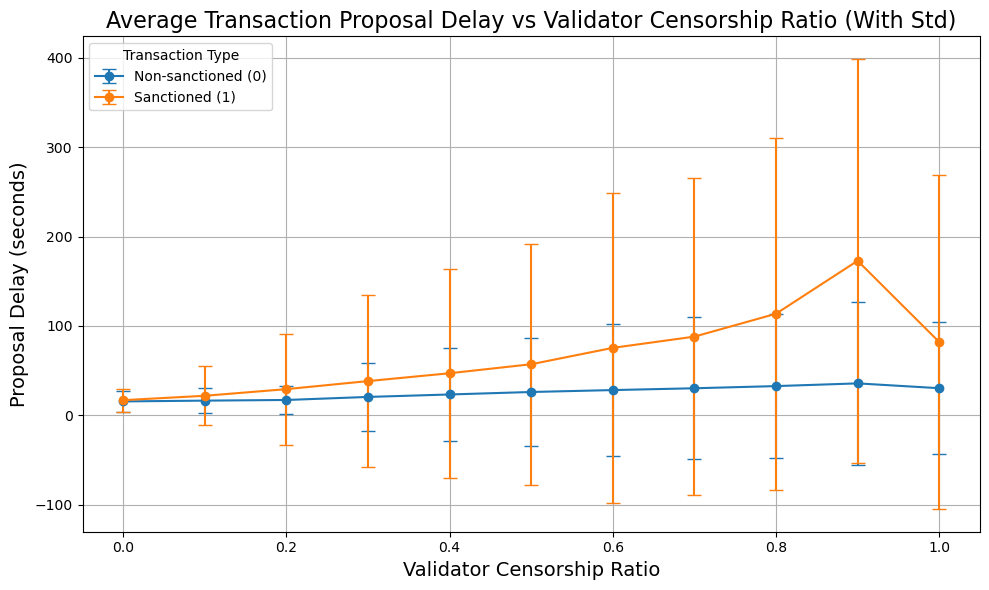

In [ ]:

final_stats['validator_censorship_ratio'] = final_stats['experiment'].str.extract(r'vcr_(\d+\.\d+)').astype(float)


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.plot(group['validator_censorship_ratio'], group['mean'], '-o', label=label)

ax.set_xlabel('Validator Censorship Ratio', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Validator Censorship Ratio', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.errorbar(group['validator_censorship_ratio'], group['mean'], yerr=group['std'],
                fmt='-o', label=label, capsize=5)

ax.set_xlabel('Validator Censorship Ratio', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Validator Censorship Ratio (With Std)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


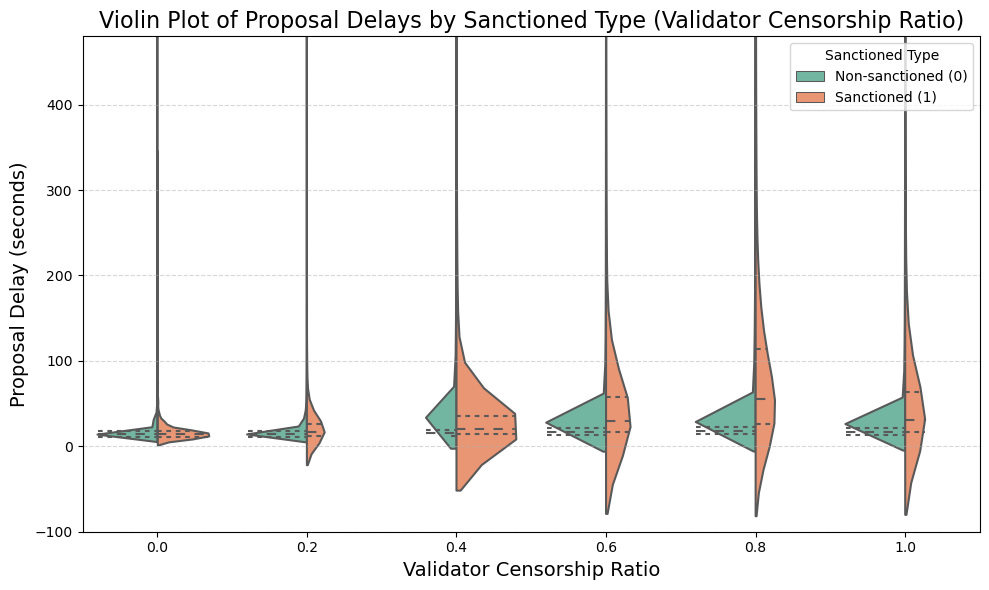

In [ ]:



selected_experiments = ['0.000', '0.200', '0.400', '0.600', '0.800', '1.000']

plt.figure(figsize=(10, 6))


validator_ratio_filtered = combined_transactions[
    combined_transactions['experiment'].str.contains('vcr_') &
    combined_transactions['experiment'].str[-5:].isin(selected_experiments)
]

sns.violinplot(
    data=validator_ratio_filtered,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)


current_labels = plt.gca().get_xticklabels()
new_labels = [f"{float(label.get_text()[-5:]):.1f}" for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.ylim(-100, 480)
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type (Validator Censorship Ratio)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
#### -  validator_censorship_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_validator_censorship_ratio_20250612_103135"


folders = [f for f in os.listdir(base_dir) if f.startswith("validator_censorship_ratio_")]


def extract_validator_ratio(folder_name):
    match = re.search(r"validator_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_validator_ratio)


results = []

for folder in folders:
    validator_ratio = extract_validator_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()


    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks

  
        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })

 
    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'experiment': f'vcr_{validator_ratio:.3f}',
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: vcr_{validator_ratio:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")



Experiment: vcr_0.000
平均含 sanctioned_type=1 交易的区块数量: 153.500000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 146.300000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.20%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.80%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: vcr_0.100
平均含 sanctioned_type=1 交易的区块数量: 146.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 153.300000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.85%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.15%
平均空区块数量: 0.300000
空区块占所有已提议区块的比例: 0.10%

Experiment: vcr_0.200
平均含 sanctioned_type=1 交易的区块数量: 138.300000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 161.400000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 46.15%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 53.85%
平均空区块数量: 0.300000
空区块占所有已提议区块的比例: 0.10%

Experiment: vcr_0.300
平均含 sanctioned_type=1 交易的区块数量: 131.600000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 167.100000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 44.06%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 55.94%
平均空区块数量: 1.300000
空区块占所有已提议区块的比例: 0.43%


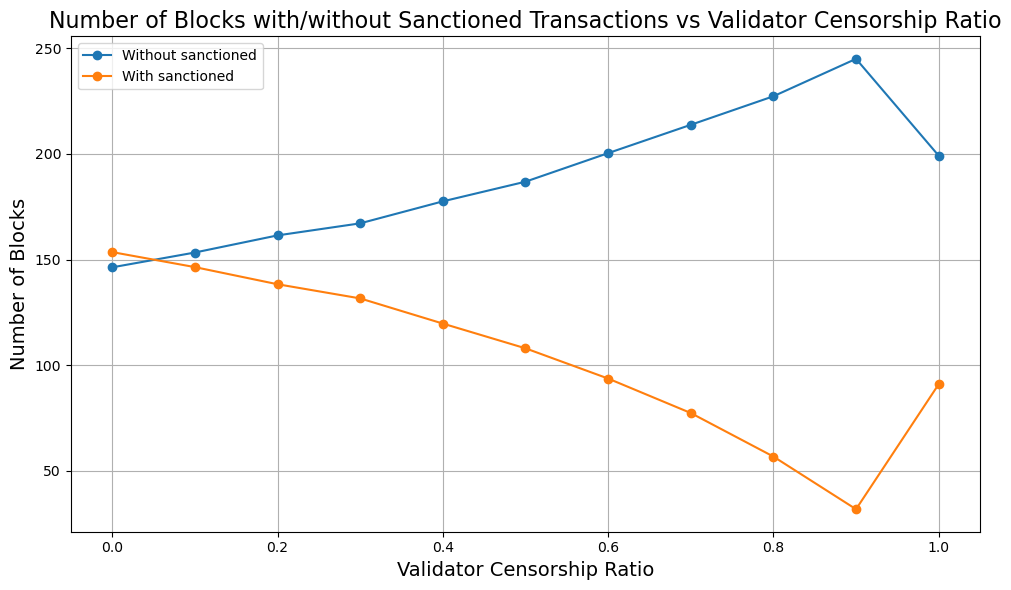

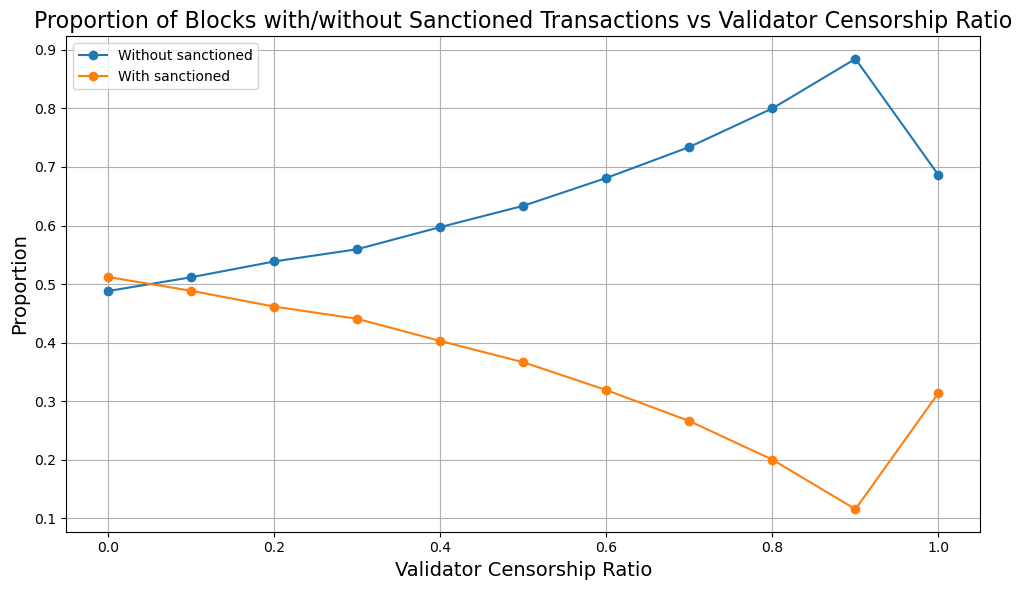

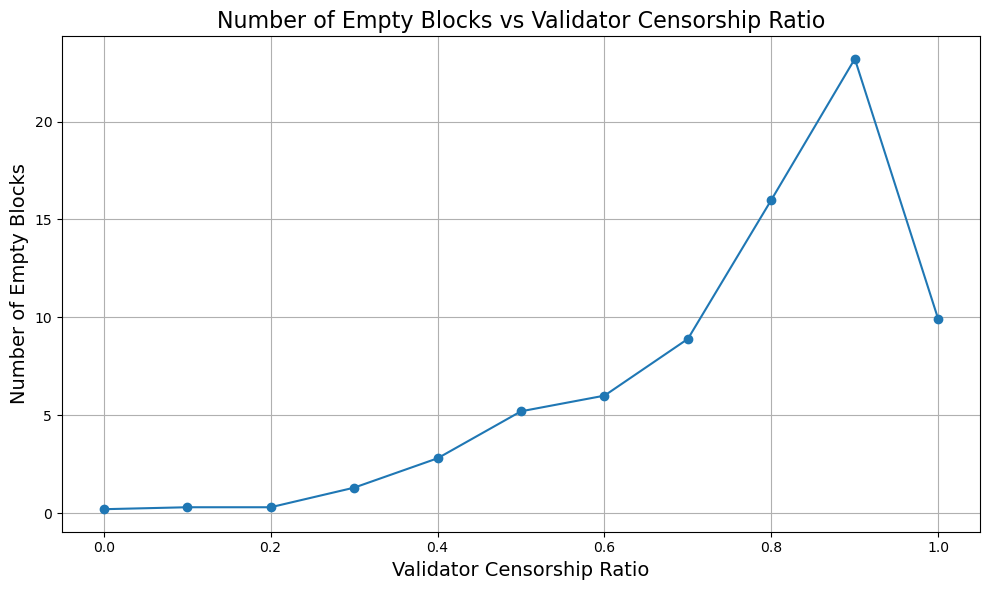

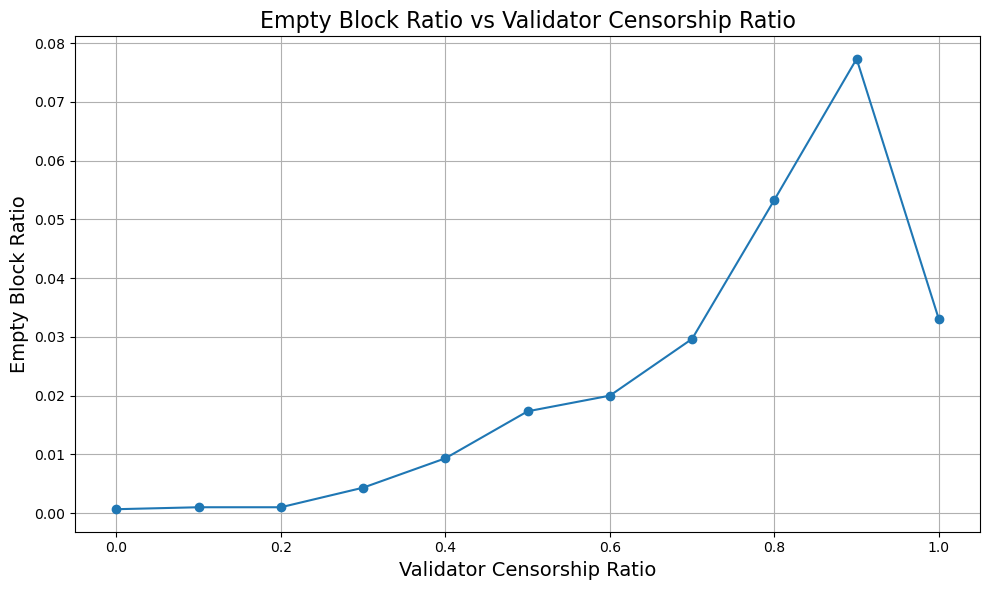

In [ ]:

results_df = pd.DataFrame(results)
results_df['validator_ratio'] = results_df['experiment'].str.extract(r'vcr_(\d+\.\d+)').astype(float)

# Figure 1: Average number of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['validator_ratio'], results_df['avg_blocks_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['validator_ratio'], results_df['avg_blocks_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Number of Blocks', fontsize=14)
plt.title('Number of Blocks with/without Sanctioned Transactions vs Validator Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Proportion of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['validator_ratio'], results_df['ratio_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['validator_ratio'], results_df['ratio_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Proportion of Blocks with/without Sanctioned Transactions vs Validator Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 3: Average number of empty blocks
plt.figure(figsize=(10, 6))
plt.plot(results_df['validator_ratio'], results_df['avg_empty_blocks'], marker='o')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Number of Empty Blocks', fontsize=14)
plt.title('Number of Empty Blocks vs Validator Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 4: Empty block ratio
plt.figure(figsize=(10, 6))
plt.plot(results_df['validator_ratio'], results_df['empty_block_ratio'], marker='o')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Empty Block Ratio', fontsize=14)
plt.title('Empty Block Ratio vs Validator Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### total_block_value，mean_block_value  - validator_censorship_ratio

In [ ]:

# Calculate block value statistics
def calculate_block_value_stats(exp_blocks, validator_ratio):
  
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

    
    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']

   
    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

   
    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'validator_ratio': validator_ratio,
        'avg_total_block_value': avg_total_block_value,
        'avg_mean_block_value': avg_mean_block_value,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }


不同validator_censorship_ratio参数下的总区块价值和平均区块价值:
    validator_ratio  avg_total_block_value  avg_mean_block_value  \
0               0.0           1.190937e+10          3.972460e+07   
1               0.1           1.190911e+10          3.973698e+07   
2               0.2           1.190775e+10          3.973251e+07   
3               0.3           1.190803e+10          3.986763e+07   
4               0.4           1.190663e+10          4.006630e+07   
5               0.5           1.190253e+10          4.037938e+07   
6               0.6           1.189927e+10          4.048565e+07   
7               0.7           1.188841e+10          4.085266e+07   
8               0.8           1.186122e+10          4.177015e+07   
9               0.9           1.181119e+10          4.267833e+07   
10              1.0           1.188612e+10          4.098004e+07   

    avg_total_block_value_eth  avg_mean_block_value_eth  
0                   11.909374                  0.039725  
1                   1

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


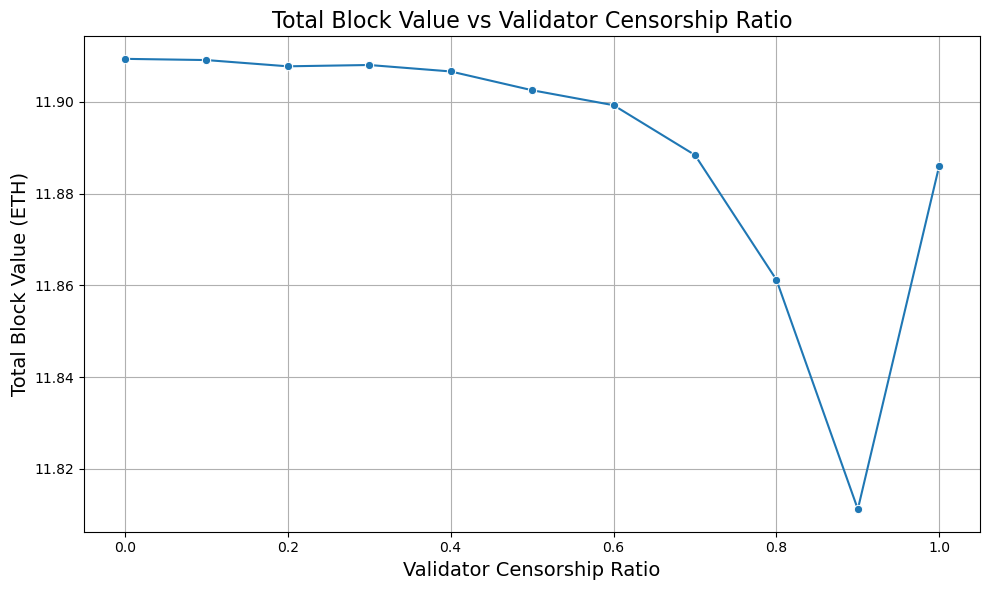

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


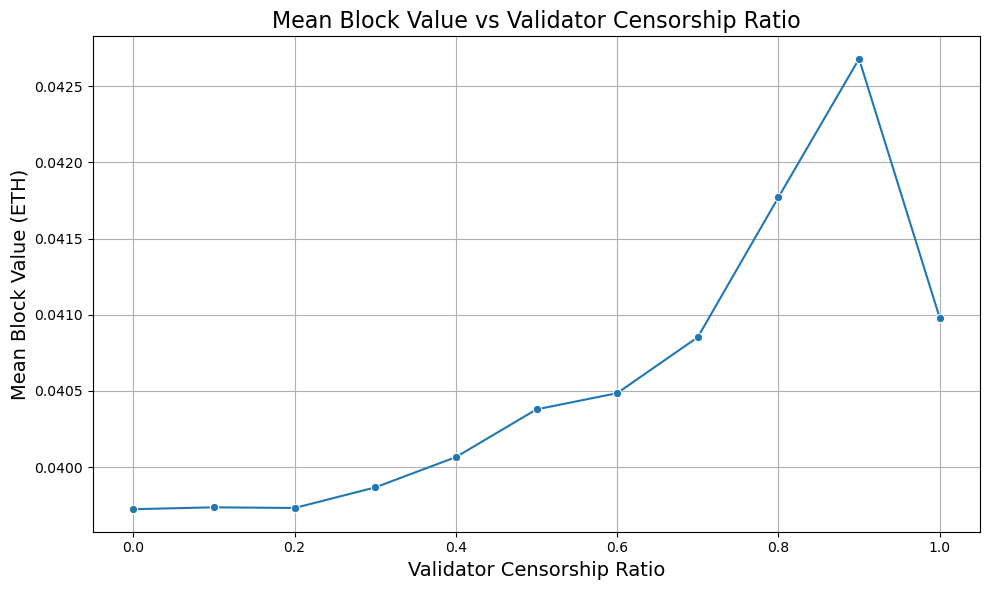

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_validator_censorship_ratio_20250612_103135"


def extract_validator_ratio(folder_name):
    match = re.search(r"validator_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("validator_censorship_ratio_")]
folders.sort(key=extract_validator_ratio)

results = []


for folder in folders:
    validator_ratio = extract_validator_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_block_value_stats(blocks, validator_ratio)
    results.append(stats)


combined_stats = pd.DataFrame(results)


print("不同validator_censorship_ratio参数下的总区块价值和平均区块价值:")
print(combined_stats.sort_values('validator_ratio'))

# Figure 1: Total Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='validator_ratio', y='avg_total_block_value_eth', marker='o')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.title('Total Block Value vs Validator Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Block Value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='validator_ratio', y='avg_mean_block_value_eth', marker='o')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Mean Block Value (ETH)', fontsize=14)
plt.title('Mean Block Value vs Validator Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for builders under different censorship types  - validator_censorship_ratio

In [ ]:
# Calculate builder profit by policy
def calculate_builder_profit_by_policy(exp_blocks, experiment_name):
    
    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()

    
    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )

    
    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()

   
    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


  builder_policy  mean_builder_profit_per_block(ETH)  \
0            non                            0.001987   
1         strict                            0.001975   
2           weak                            0.001986   
0            non                            0.002003   
1         strict                            0.001878   
2           weak                            0.002011   
0            non                            0.002045   
1         strict                            0.001782   
2           weak                            0.001993   
0            non                            0.002076   
1         strict                            0.001771   
2           weak                            0.001976   
0            non                            0.002111   
1         strict                            0.001802   
2           weak                            0.002032   
0            non                            0.002165   
1         strict                            0.00

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

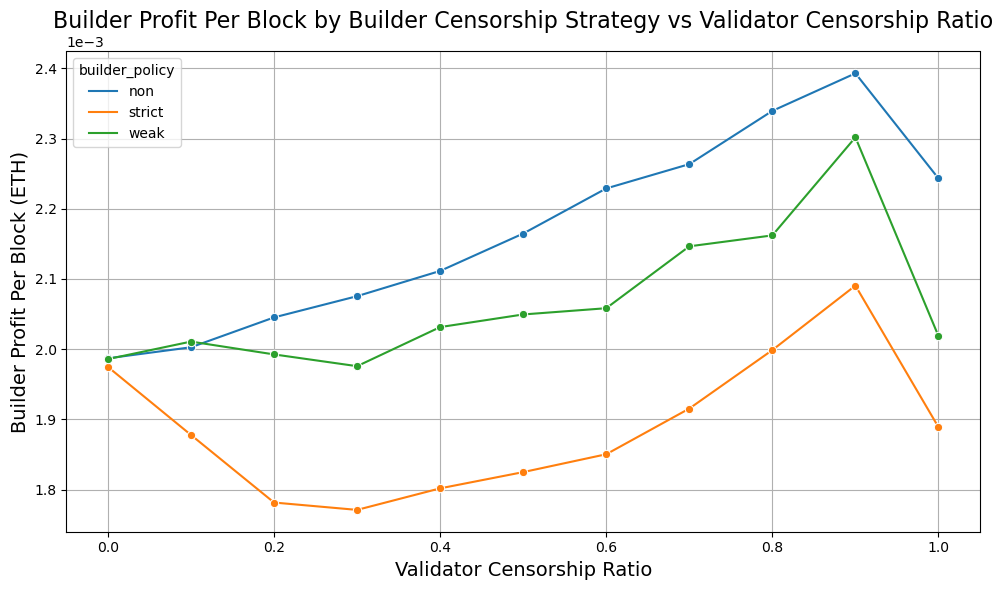

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

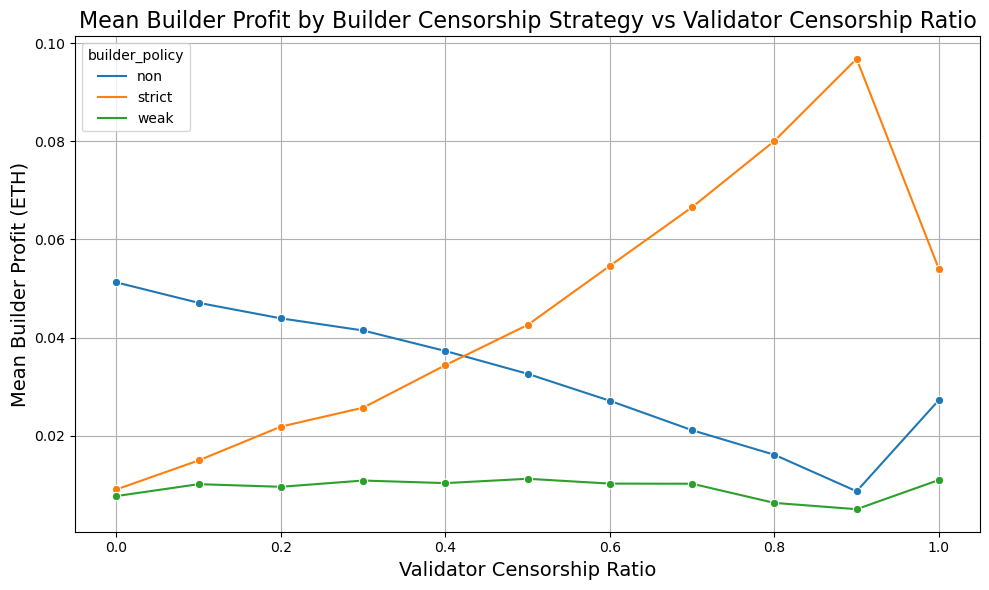

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_validator_censorship_ratio_20250612_103135"


folders = [f for f in os.listdir(base_dir) if f.startswith("validator_censorship_ratio_")]


def extract_validator_ratio(folder_name):
    match = re.search(r"validator_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_validator_ratio)

results = []


for folder in folders:
    validator_ratio = extract_validator_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

   
    stats = calculate_builder_profit_by_policy(blocks, f'vcr_{validator_ratio:.3f}')
    stats['validator_ratio'] = validator_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['validator_ratio', 'builder_policy']))

# Figure 1：Builder Profit Per Block by Builder Censorship Strategy vs Validator Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='validator_ratio', y='mean_builder_profit_per_block(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Builder Profit Per Block (ETH)', fontsize=14)
plt.title('Builder Profit Per Block by Builder Censorship Strategy vs Validator Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2：Mean Builder Profit by Builder Censorship Strategy vs Validator Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='validator_ratio', y='mean_builder_profit_per_builder(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Mean Builder Profit (ETH)', fontsize=14)
plt.title('Mean Builder Profit by Builder Censorship Strategy vs Validator Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for validators under different censorship types  - validator_censorship_ratio

In [ ]:

# Calculate validator profit by policy

def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]


   proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                            False                              0.037738   
1                             True                              0.000000   
0                            False                              0.038344   
1                             True                              0.031913   
0                            False                              0.039107   
1                             True                              0.032139   
0                            False                              0.039918   
1                             True                              0.032654   
0                            False                              0.040711   
1                             True                              0.033674   
0                            False                              0.041904   
1                             True                              0.034442   
0           

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

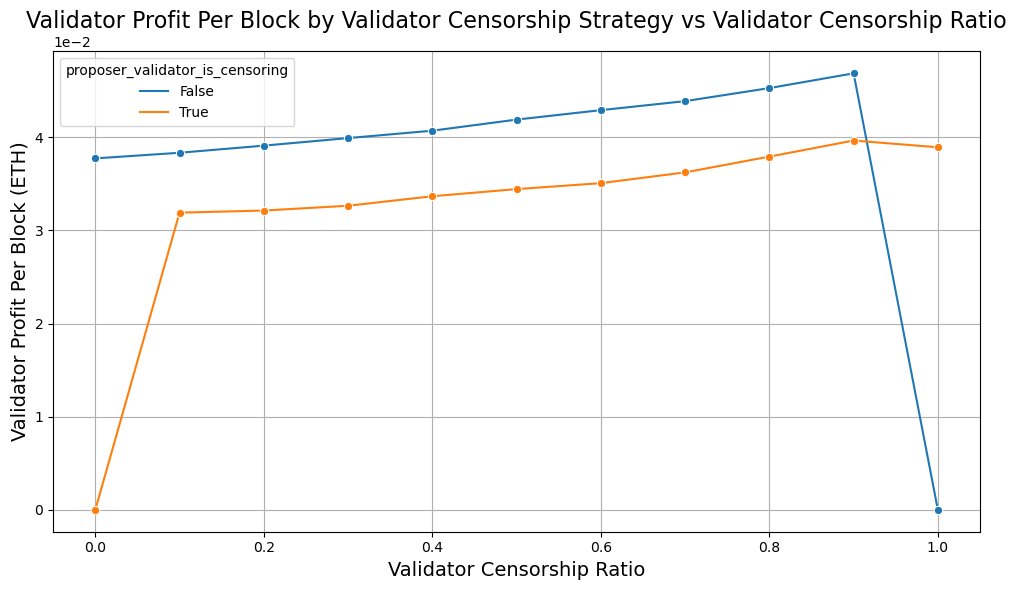

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

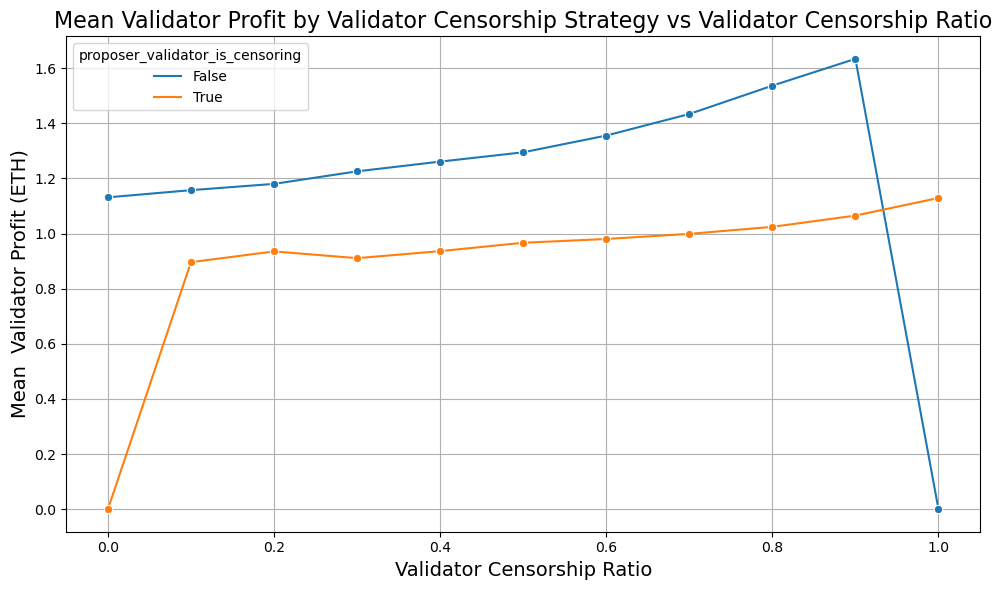

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_validator_censorship_ratio_20250612_103135"


folders = [f for f in os.listdir(base_dir) if f.startswith("validator_censorship_ratio_")]


def extract_validator_ratio(folder_name):
    match = re.search(r"validator_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_validator_ratio)

results = []


for folder in folders:
    validator_ratio = extract_validator_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

   
    stats = calculate_validator_profit_by_policy(blocks, f'vcr_{validator_ratio:.3f}')
    stats['validator_ratio'] = validator_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['validator_ratio', 'proposer_validator_is_censoring']))

# Figure 1：Validator Profit Per Block by Validator Censorship Strategy vs Validator Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='validator_ratio', y='mean_validator_profit_per_block(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Validator Profit Per Block (ETH)', fontsize=14)
plt.title('Validator Profit Per Block by Validator Censorship Strategy vs Validator Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2：Mean Validator Profit by Validator Censorship Strategy vs Validator Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='validator_ratio', y='mean_validator_profit_per_validator(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Validator Censorship Ratio', fontsize=14)
plt.ylabel('Mean  Validator Profit (ETH)', fontsize=14)
plt.title('Mean Validator Profit by Validator Censorship Strategy vs Validator Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Two factor analysis - builder_censorship_ratio & relay_censorship_ratio

#### Transaction Delay - builder_censorship_ratio & relay_censorship_ratio

In [ ]:



base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_censorship_ratio_20250610_145045"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_censorship_ratio_")]


def extract_builder_relay_ratios(folder_name):
    match = re.search(r"builder_relay_censorship_ratio_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        builder_ratio = float(match.group(1))
        relay_ratio = float(match.group(2))
        return (builder_ratio, relay_ratio)
    else:
        return (float('inf'), float('inf'))

folders.sort(key=extract_builder_relay_ratios)


for folder in folders:
    builder_ratio, relay_ratio = extract_builder_relay_ratios(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})

    
    transactions['experiment'] = f"bcr_{builder_ratio:.1f}_bcr_{relay_ratio:.1f}"
    transactions['builder_ratio'] = builder_ratio
    transactions['relay_ratio'] = relay_ratio

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['builder_ratio', 'relay_ratio', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()

final_stats = run_stats.groupby(['builder_ratio', 'relay_ratio', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Builder & Relay Censorship Ratio and Sanctioned Type (averaged by run_id):")
# print(final_stats)

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  

display(final_stats)

Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment, builder_ratio, relay_ratio]
Index: []

[0 rows x 25 columns]

Proposal Delay Statistics by Builder & Relay Censorship Ratio and Sanctioned Type (averaged by run_id):


builder_ratio  relay_ratio     sanctioned_type        mean         std
0              0.0          0.0  Non-sanctioned (0)   15.500621   12.333309
1              0.0          0.0      Sanctioned (1)   15.784350   11.796817
2              0.0          0.1  Non-sanctioned (0)   37.443379  120.358862
3              0.0          0.1      Sanctioned (1)   49.984462  155.564737
4              0.0          0.2  Non-sanctioned (0)   35.521705  111.578095
5              0.0          0.2      Sanctioned (1)   46.498330  146.161187
6              0.0          0.4  Non-sanctioned (0)   35.861677  113.516942
7              0.0          0.4      Sanctioned (1)   47.873350  138.169488
8              0.0          0.6  Non-sanctioned (0)   39.453337  128.176194
9              0.0          0.6      Sanctioned (1)   51.716853  155.943072
10             0.0          0.8  Non-sanctioned (0)   37.332938  120.639632
11             0.0          0.8      Sanctioned (1)   47.233673  128.057227
12             0.0          0.9  Non-sanctioned (0)   41.004139  138.240446
13             0.0          0.9      Sanctioned (1)   59.377271  184.762392
14             0.0          1.0  Non-sanctioned (0)  155.903840  206.998545
15             0.1          0.0  Non-sanctioned (0)   15.475733   12.204569
16             0.1          0.0      Sanctioned (1)   16.140222   12.605684
17             0.1          0.1  Non-sanctioned (0)   20.796002   39.228735
18             0.1          0.1      Sanctioned (1)   32.116380   82.286871
19             0.1          0.2  Non-sanctioned (0)   19.397765   27.980662
20             0.1          0.2      Sanctioned (1)   30.379854   76.465439
21             0.1          0.4  Non-sanctioned (0)   20.604040   37.811792
22             0.1          0.4      Sanctioned (1)   30.455882   71.043469
23             0.1          0.6  Non-sanctioned (0)   20.767907   40.132130
24             0.1          0.6      Sanctioned (1)   35.190019   94.223219
25             0.1          0.8  Non-sanctioned (0)   20.691201   40.415516
26             0.1          0.8      Sanctioned (1)   35.557465  101.137007
27             0.1          0.9  Non-sanctioned (0)   21.838149   47.077239
28             0.1          0.9      Sanctioned (1)   34.701846   96.543923
29             0.1          1.0  Non-sanctioned (0)   54.424686  138.914263
30             0.2          0.0  Non-sanctioned (0)   15.504530   12.440157
31             0.2          0.0      Sanctioned (1)   16.467155   12.771060
32             0.2          0.1  Non-sanctioned (0)   18.298409   23.119567
33             0.2          0.1      Sanctioned (1)   30.180654   71.305469
34             0.2          0.2  Non-sanctioned (0)   20.085052   32.872121
35             0.2          0.2      Sanctioned (1)   32.645458   76.127602
36             0.2          0.4  Non-sanctioned (0)   18.839171   27.101211
37             0.2          0.4      Sanctioned (1)   29.477769   63.218990
38             0.2          0.6  Non-sanctioned (0)   19.515896   32.420179
39             0.2          0.6      Sanctioned (1)   33.532755   88.096274
40             0.2          0.8  Non-sanctioned (0)   18.021041   21.191029
41             0.2          0.8      Sanctioned (1)   28.519704   58.664340
42             0.2          0.9  Non-sanctioned (0)   18.757522   25.452483
43             0.2          0.9      Sanctioned (1)   33.750062   88.794534
44             0.2          1.0  Non-sanctioned (0)   41.224290  114.853207
45             0.4          0.0  Non-sanctioned (0)   15.510112   12.359142
46             0.4          0.0      Sanctioned (1)   16.803884   12.312981
47             0.4          0.1  Non-sanctioned (0)   18.270115   22.660633
48             0.4          0.1      Sanctioned (1)   31.790856   77.054719
49             0.4          0.2  Non-sanctioned (0)   19.735471   32.938839
50             0.4          0.2      Sanctioned (1)   32.575289   77.874786
51             0.4          0.4  Non-sanctioned (0)  

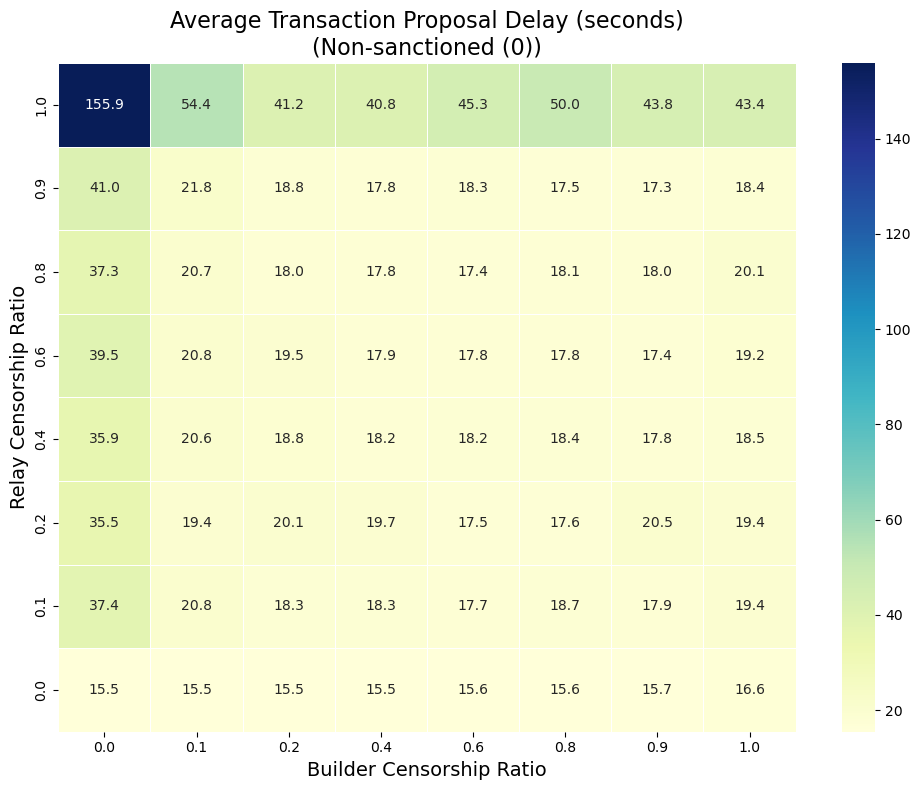

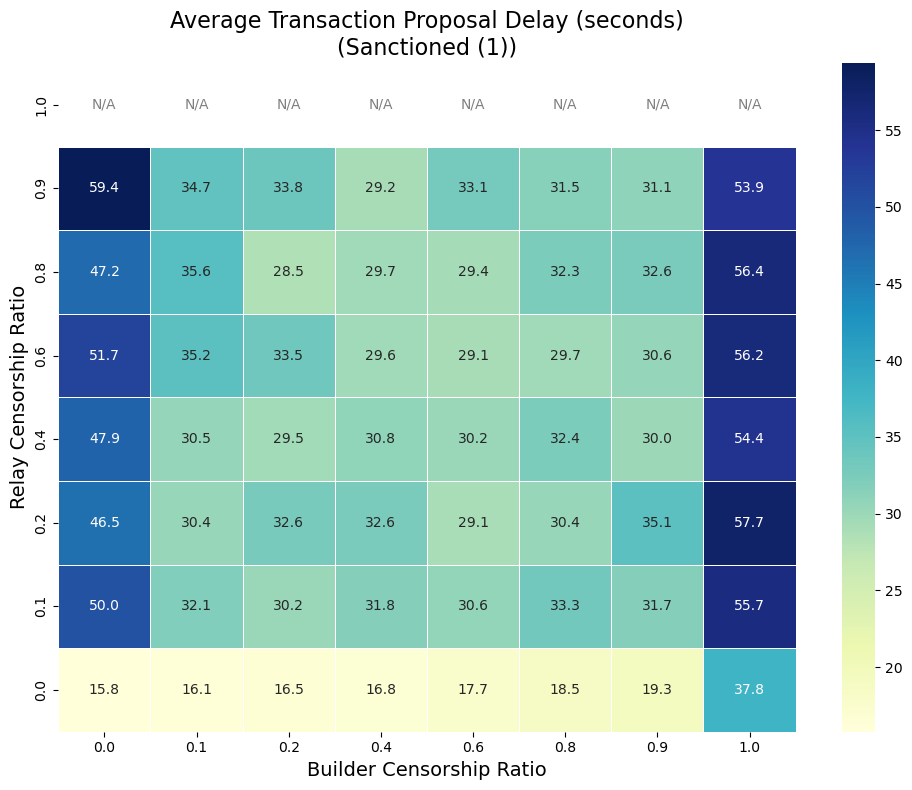

In [ ]:

full_relay_ratios = sorted(final_stats['relay_ratio'].unique())
full_builder_ratios = sorted(final_stats['builder_ratio'].unique())

for sanctioned_type in final_stats['sanctioned_type'].unique():
    subset = final_stats[final_stats['sanctioned_type'] == sanctioned_type]

    heatmap_data = subset.pivot(index='relay_ratio', columns='builder_ratio', values='mean').reindex(index=full_relay_ratios, columns=full_builder_ratios)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        linewidths=.5,
        # cbar_kws={'label': 'Mean Proposal Delay (s)'},
        mask=heatmap_data.isnull(),  
    )


    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            if pd.isna(heatmap_data.iloc[i, j]):
                ax.text(
                    j + 0.5, i + 0.5, 'N/A',
                    ha='center', va='center', color='grey'
                )

  
    ax.invert_yaxis()

    plt.title(f'Average Transaction Proposal Delay (seconds)\n({sanctioned_type})', fontsize=16)
    plt.xlabel('Builder Censorship Ratio', fontsize=14)
    plt.ylabel('Relay Censorship Ratio', fontsize=14)
    
    plt.tight_layout()
    plt.show()


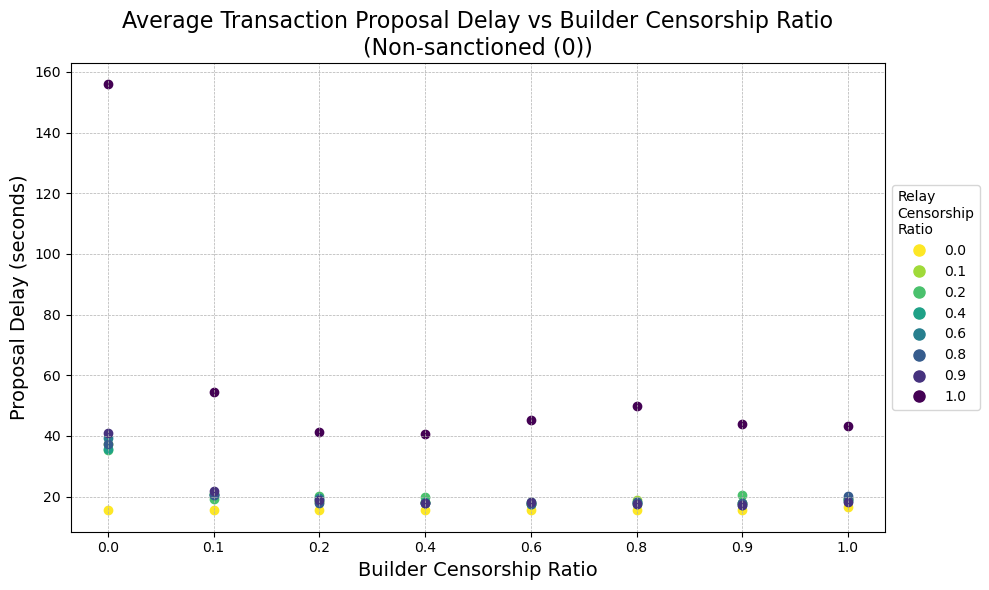

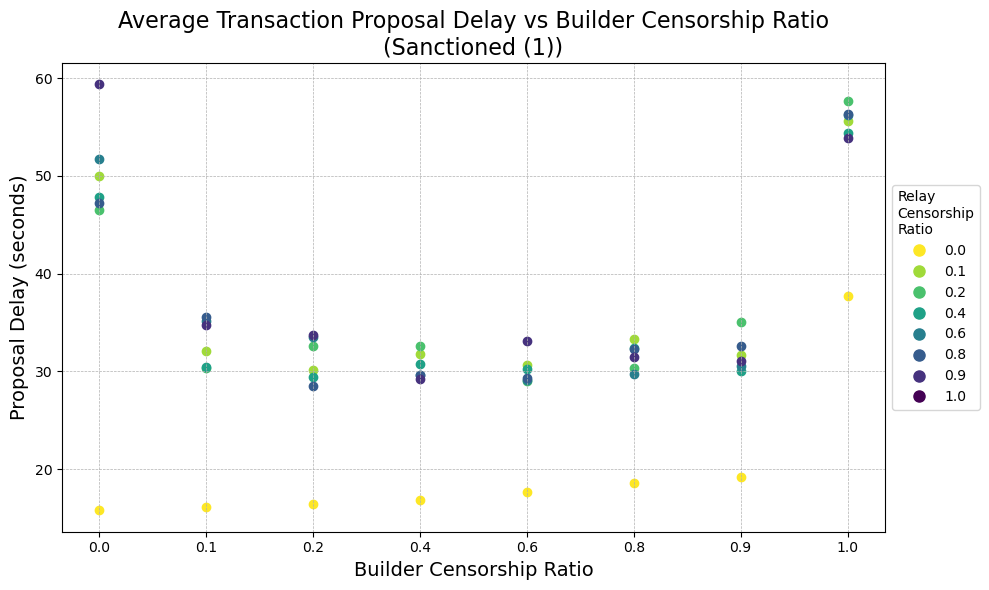

In [ ]:


relay_ratio_values = sorted(final_stats['relay_ratio'].unique())
colors = plt.cm.viridis(np.linspace(1, 0, len(relay_ratio_values)))  

for sanctioned_type in final_stats['sanctioned_type'].unique():
    subset = final_stats[final_stats['sanctioned_type'] == sanctioned_type]

    fig, ax = plt.subplots(figsize=(10, 6))


    unique_builder_ratios = sorted(subset['builder_ratio'].unique())
    builder_ratio_to_pos = {ratio: pos for pos, ratio in enumerate(unique_builder_ratios)}


    for i, relay_ratio in enumerate(relay_ratio_values):
        data = subset[subset['relay_ratio'] == relay_ratio]
        positions = [builder_ratio_to_pos[bt] for bt in data['builder_ratio']]
        ax.scatter(positions, data['mean'],
                   color=colors[i], marker='o', label=f'{relay_ratio:.1f}', alpha=1.0)

    ax.set_xlabel('Builder Censorship Ratio', fontsize=14)
    ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5)


    ax.set_xticks(range(len(unique_builder_ratios)))
    ax.set_xticklabels([f'{x:.1f}' for x in unique_builder_ratios])


    legend_elements = [plt.Line2D([0], [0], marker='o', color=colors[i], linestyle='', markersize=8, label=f'{relay_ratio:.1f}')
                       for i, relay_ratio in enumerate(relay_ratio_values)]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title='Relay\nCensorship\nRatio')

    plt.title(f'Average Transaction Proposal Delay vs Builder Censorship Ratio\n({sanctioned_type})', fontsize=16)
    plt.tight_layout()
    plt.show()

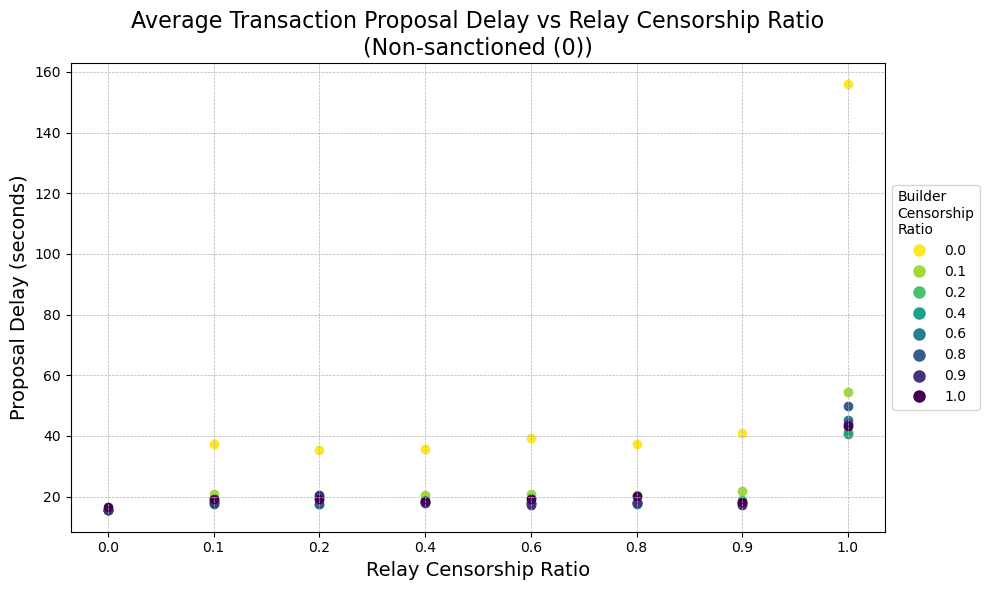

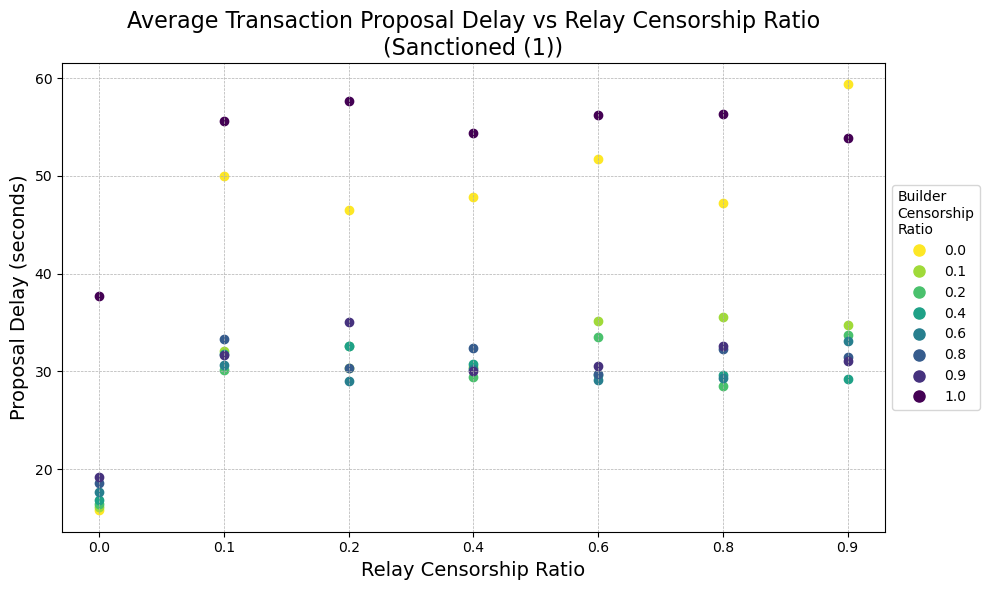

In [ ]:


builder_ratio_values = sorted(final_stats['builder_ratio'].unique())
colors = plt.cm.viridis(np.linspace(1, 0, len(builder_ratio_values))) 

for sanctioned_type in final_stats['sanctioned_type'].unique():
    subset = final_stats[final_stats['sanctioned_type'] == sanctioned_type]

    fig, ax = plt.subplots(figsize=(10, 6))


    unique_relay_ratios = sorted(subset['relay_ratio'].unique())
    relay_ratio_to_pos = {ratio: pos for pos, ratio in enumerate(unique_relay_ratios)}


    for i, builder_ratio in enumerate(builder_ratio_values):
        data = subset[subset['builder_ratio'] == builder_ratio]
        positions = [relay_ratio_to_pos[rt] for rt in data['relay_ratio']]
        ax.scatter(positions, data['mean'],
                   color=colors[i], marker='o', label=f'{builder_ratio:.1f}', alpha=1.0)

    ax.set_xlabel('Relay Censorship Ratio', fontsize=14)
    ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5)


    ax.set_xticks(range(len(unique_relay_ratios)))
    ax.set_xticklabels([f'{x:.1f}' for x in unique_relay_ratios])


    legend_elements = [plt.Line2D([0], [0], marker='o', color=colors[i], linestyle='', markersize=8, label=f'{builder_ratio:.1f}')
                       for i, builder_ratio in enumerate(builder_ratio_values)]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title='Builder\nCensorship\nRatio')

    plt.title(f'Average Transaction Proposal Delay vs Relay Censorship Ratio\n({sanctioned_type})', fontsize=16)
    plt.tight_layout()
    plt.show()


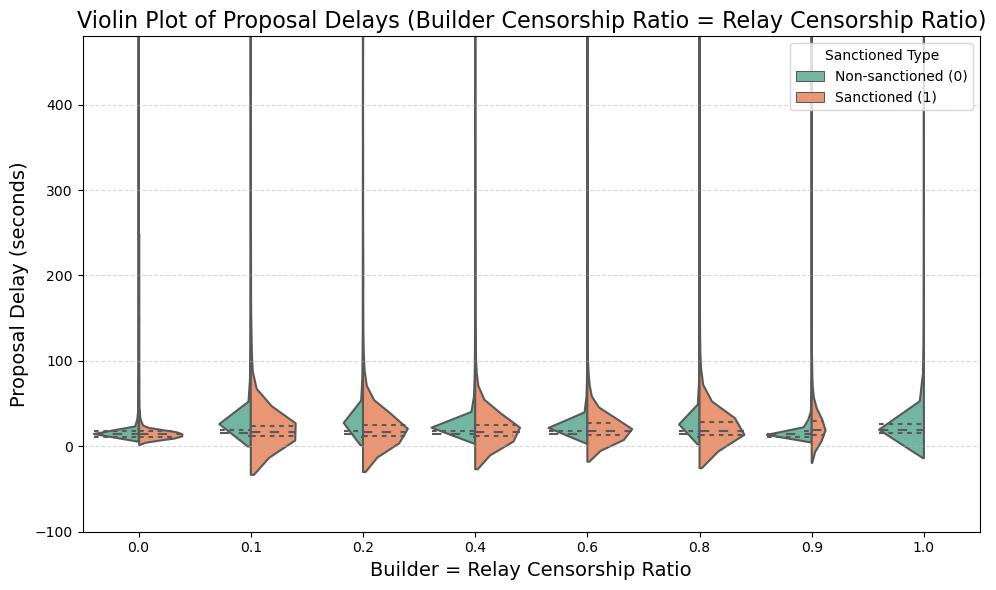

In [ ]:



selected_ratios = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]

selected_data = combined_transactions[
    combined_transactions['builder_ratio'].isin(selected_ratios) &
    (combined_transactions['builder_ratio'] == combined_transactions['relay_ratio'])
].copy()


selected_data['ratio_label'] = selected_data['builder_ratio'].apply(lambda x: f"{x:.1f}")

plt.figure(figsize=(10, 6))

sns.violinplot(
    data=selected_data,
    x='ratio_label',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)

plt.ylim(-100, 480)
plt.xlabel('Builder = Relay Censorship Ratio', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays (Builder Censorship Ratio = Relay Censorship Ratio)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


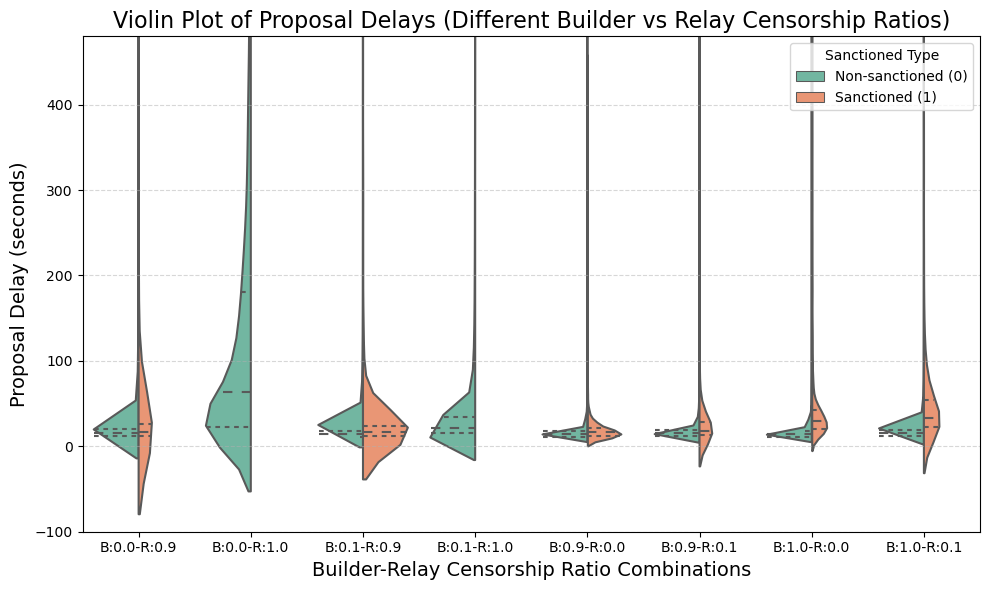

In [ ]:

diff_ratios = [
    (0.0, 1.0),
    (0.0, 0.9),
    (0.1, 1.0),
    (0.1, 0.9),
    (1.0, 0.0),
    (0.9, 0.0),
    (1.0, 0.1),
    (0.9, 0.1)
]

selected_data = combined_transactions[
    combined_transactions.apply(
        lambda row: (row['builder_ratio'], row['relay_ratio']) in diff_ratios, axis=1
    )
].copy()


selected_data['ratio_label'] = selected_data.apply(
    lambda row: f"B:{row['builder_ratio']:.1f}-R:{row['relay_ratio']:.1f}", axis=1
)

plt.figure(figsize=(10, 6))

sns.violinplot(
    data=selected_data,
    x='ratio_label',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)

plt.ylim(-100, 480)
plt.xlabel('Builder-Relay Censorship Ratio Combinations', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays (Different Builder vs Relay Censorship Ratios)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
####  -  builder_censorship_ratio & relay_censorship_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_censorship_ratio_20250610_145045"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_censorship_ratio_")]


def extract_builder_relay_ratios(folder_name):
    match = re.search(r"builder_relay_censorship_ratio_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        builder_ratio = float(match.group(1))
        relay_ratio = float(match.group(2))
        return (builder_ratio, relay_ratio)
    else:
        return (float('inf'), float('inf'))

folders.sort(key=extract_builder_relay_ratios)


results = []

for folder in folders:
    builder_ratio, relay_ratio = extract_builder_relay_ratios(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()

 
    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks


        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })


    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'builder_ratio': builder_ratio,
        'relay_ratio': relay_ratio,
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: bcr_{builder_ratio:.1f}_rcr_{relay_ratio:.1f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")


Experiment: bcr_0.0_rcr_0.0
平均含 sanctioned_type=1 交易的区块数量: 159.200000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 140.600000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 53.10%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 46.90%
平均空区块数量: 0.200000
空区块占所有已提议区块的比例: 0.07%

Experiment: bcr_0.0_rcr_0.1
平均含 sanctioned_type=1 交易的区块数量: 142.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 139.700000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 50.49%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 49.51%
平均空区块数量: 17.900000
空区块占所有已提议区块的比例: 5.97%

Experiment: bcr_0.0_rcr_0.2
平均含 sanctioned_type=1 交易的区块数量: 142.300000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 140.600000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 50.30%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 49.70%
平均空区块数量: 17.100000
空区块占所有已提议区块的比例: 5.70%

Experiment: bcr_0.0_rcr_0.4
平均含 sanctioned_type=1 交易的区块数量: 144.100000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 137.800000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.12%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.88%
平均空区块数量: 18.10

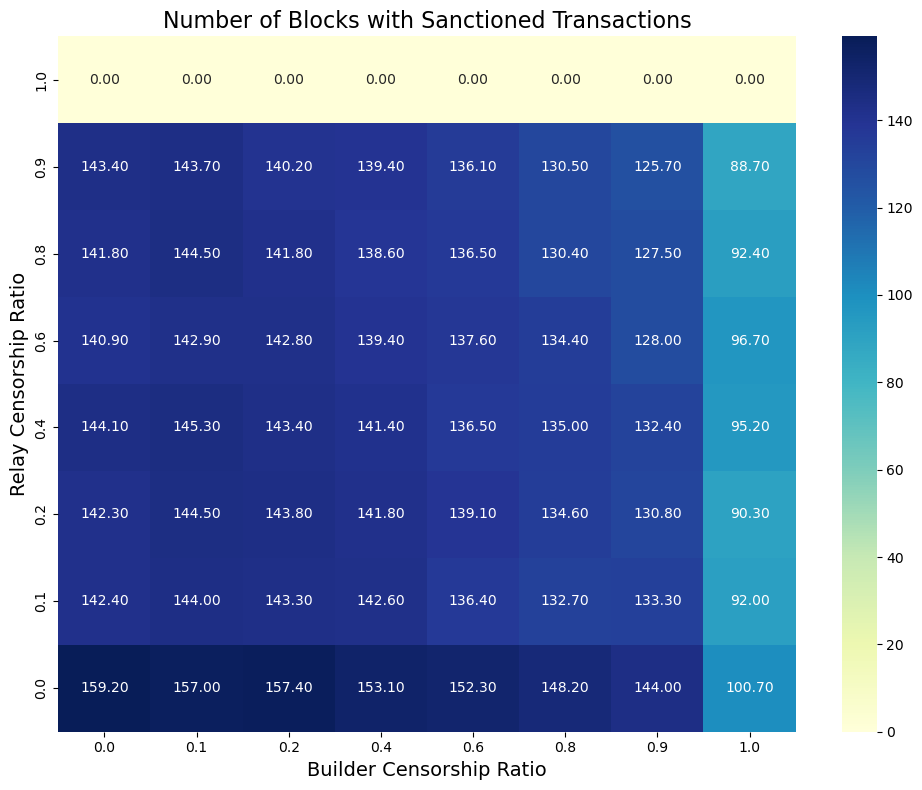

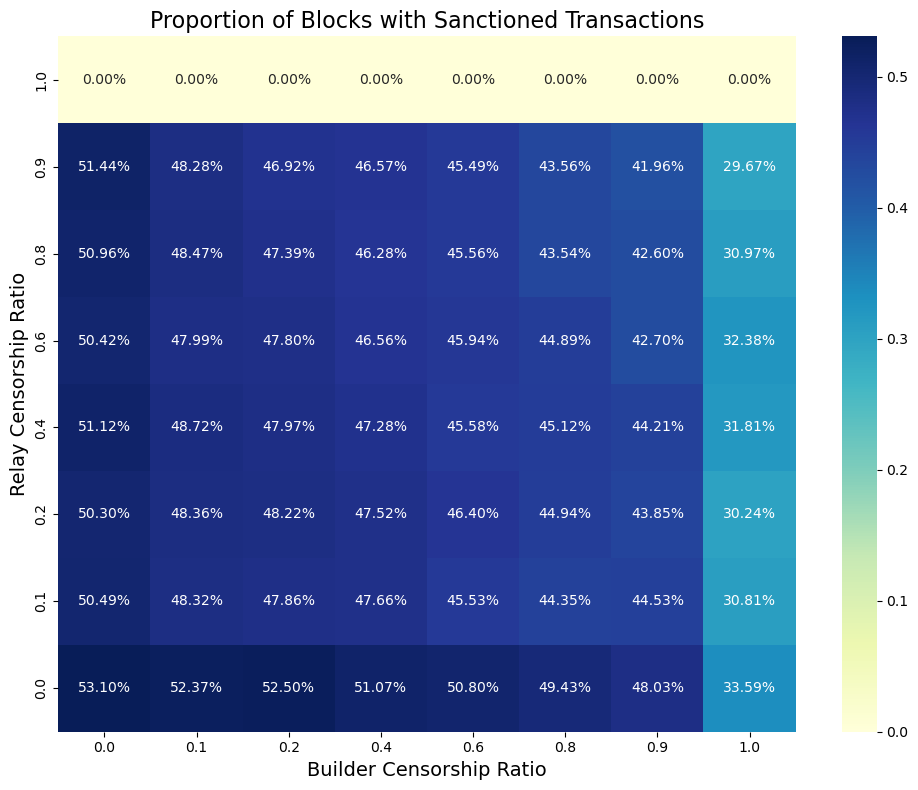

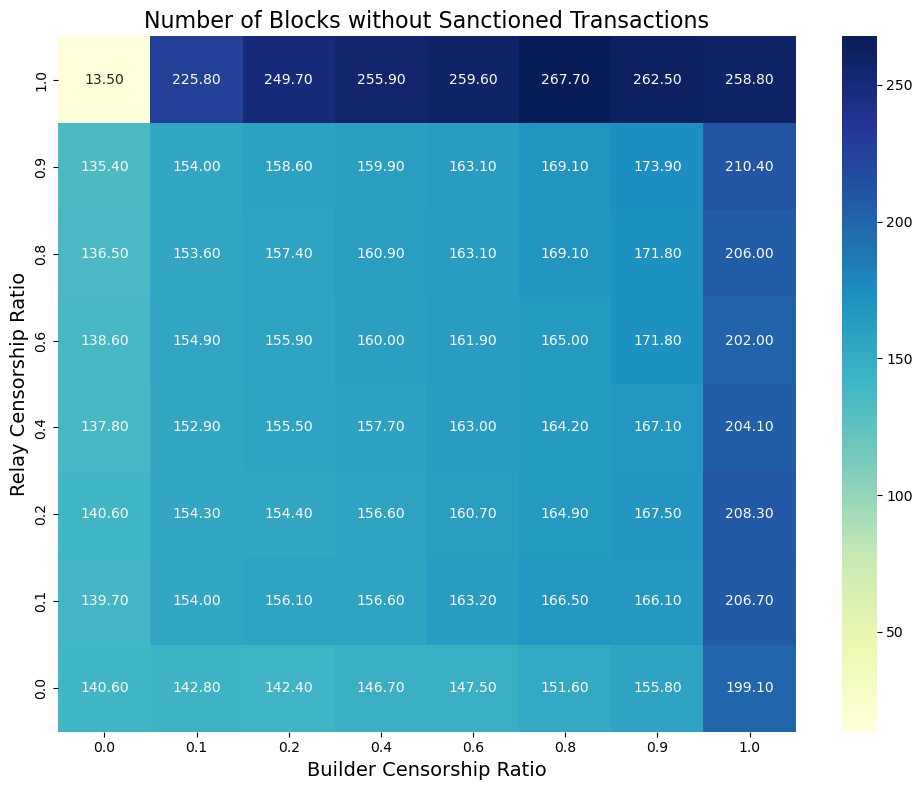

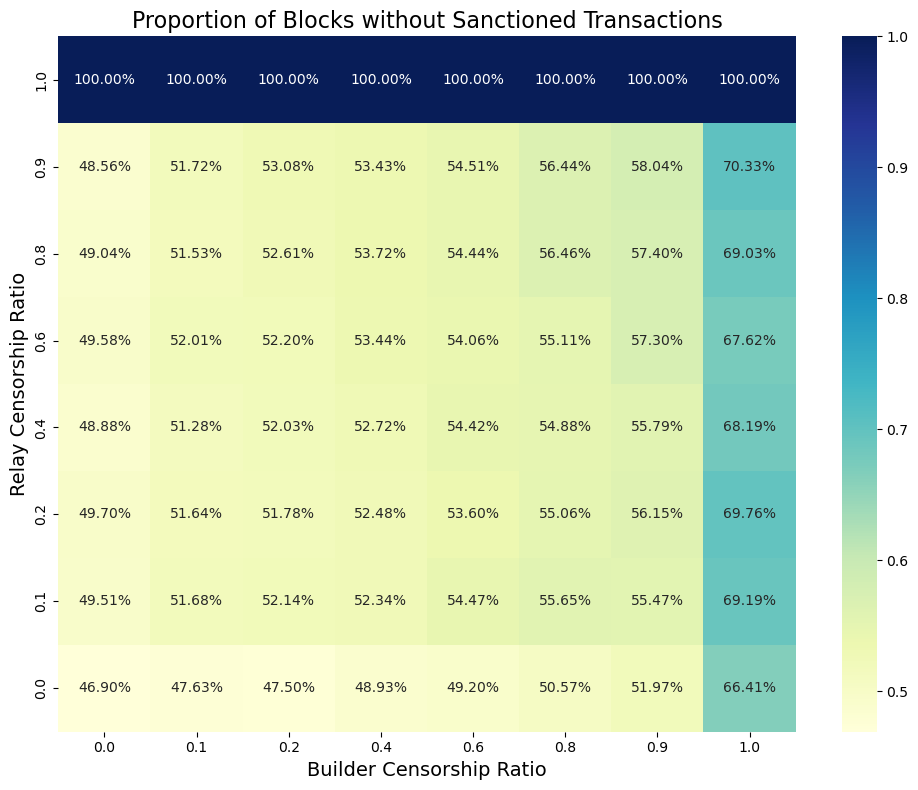

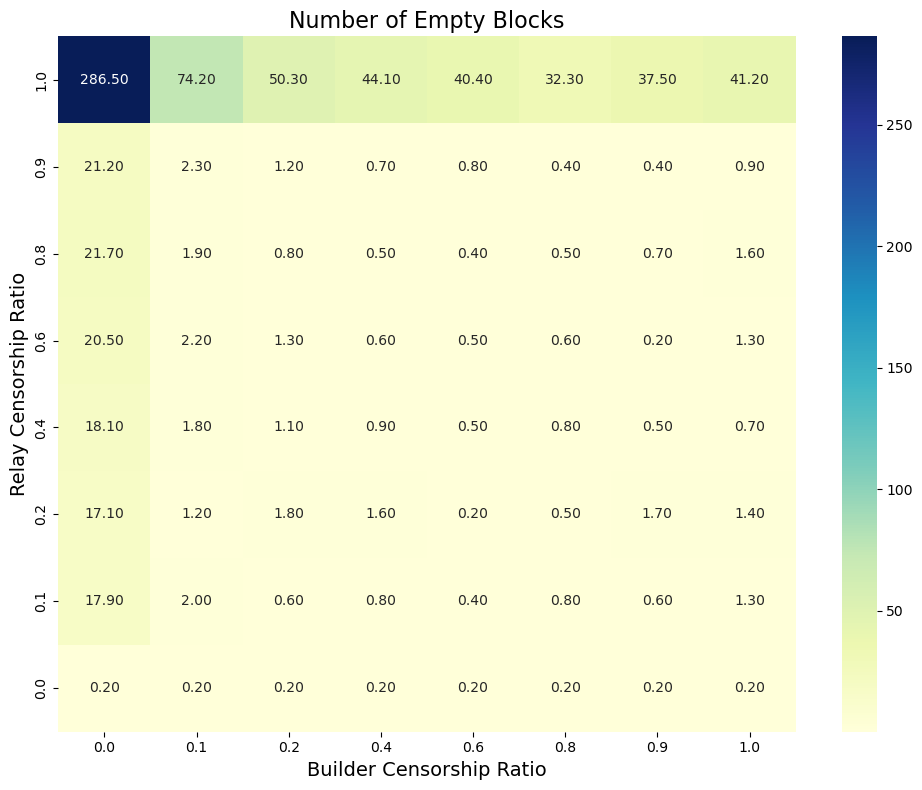

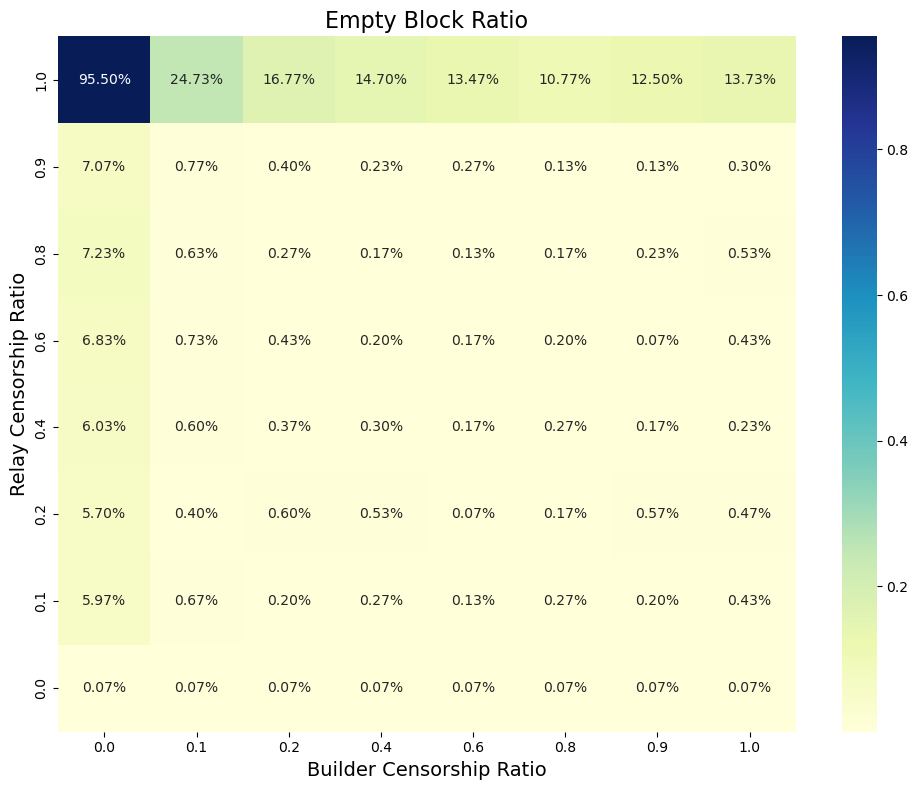

In [ ]:

results_df = pd.DataFrame(results)


def plot_heatmap(data, title, fmt):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(data, annot=True, fmt=fmt, cmap="YlGnBu")
    ax.invert_yaxis()  
    plt.xlabel('Builder Censorship Ratio', fontsize=14)
    plt.ylabel('Relay Censorship Ratio', fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Figure 1: Heatmap of average number of blocks with sanctioned transactions
heatmap_data_1 = results_df.pivot(index='relay_ratio', columns='builder_ratio', values='avg_blocks_with_sanctioned')
plot_heatmap(heatmap_data_1, 'Number of Blocks with Sanctioned Transactions', ".2f")

# Figure 2: Heatmap of proportion of blocks with sanctioned transactions
heatmap_data_2 = results_df.pivot(index='relay_ratio', columns='builder_ratio', values='ratio_with_sanctioned')
plot_heatmap(heatmap_data_2, 'Proportion of Blocks with Sanctioned Transactions', ".2%")

# Figure 3: Heatmap of average number of blocks without sanctioned transactions
heatmap_data_5 = results_df.pivot(index='relay_ratio', columns='builder_ratio', values='avg_blocks_without_sanctioned')
plot_heatmap(heatmap_data_5, 'Number of Blocks without Sanctioned Transactions', ".2f")

# Figure 4: Heatmap of proportion of blocks without sanctioned transactions
heatmap_data_6 = results_df.pivot(index='relay_ratio', columns='builder_ratio', values='ratio_without_sanctioned')
plot_heatmap(heatmap_data_6, 'Proportion of Blocks without Sanctioned Transactions', ".2%")

# Figure 5：Heatmap of average number of empty blocks
heatmap_data_3 = results_df.pivot(index='relay_ratio', columns='builder_ratio', values='avg_empty_blocks')
plot_heatmap(heatmap_data_3, 'Number of Empty Blocks', ".2f")

# Figure 6: Heatmap of empty block ratio
heatmap_data_4 = results_df.pivot(index='relay_ratio', columns='builder_ratio', values='empty_block_ratio')
plot_heatmap(heatmap_data_4, 'Empty Block Ratio', ".2%")



#### Total block value and mean block value   -  builder_censorship_ratio & relay_censorship_ratio

In [ ]:


def calculate_block_value_stats(exp_blocks, builder_ratio, relay_ratio):
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']

    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'builder_ratio': builder_ratio,
        'relay_ratio': relay_ratio,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }

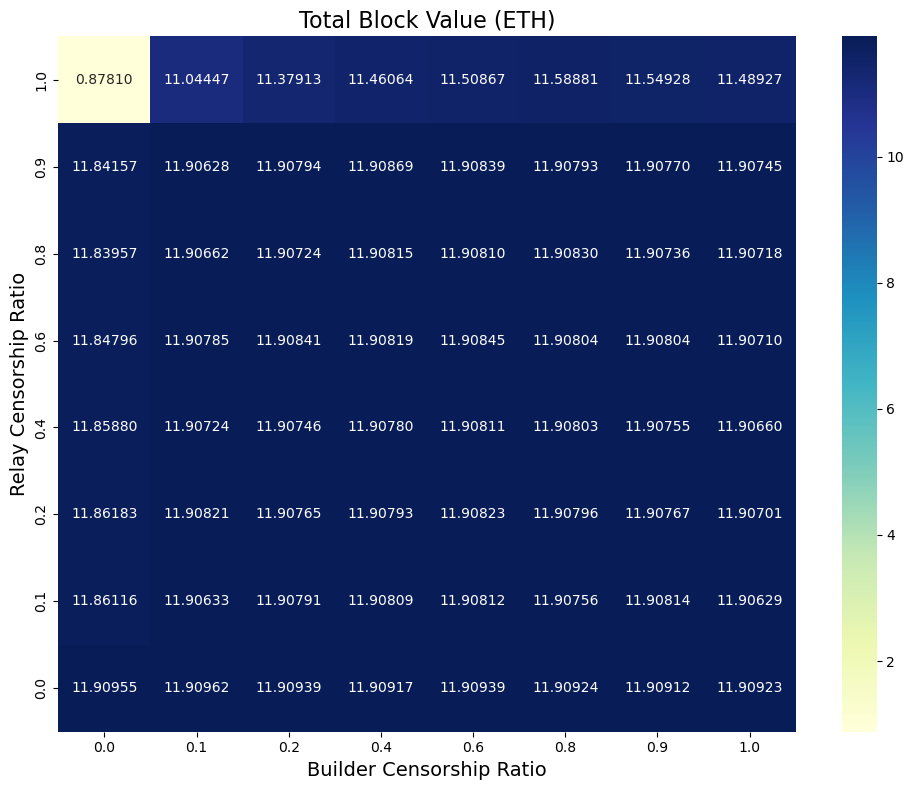

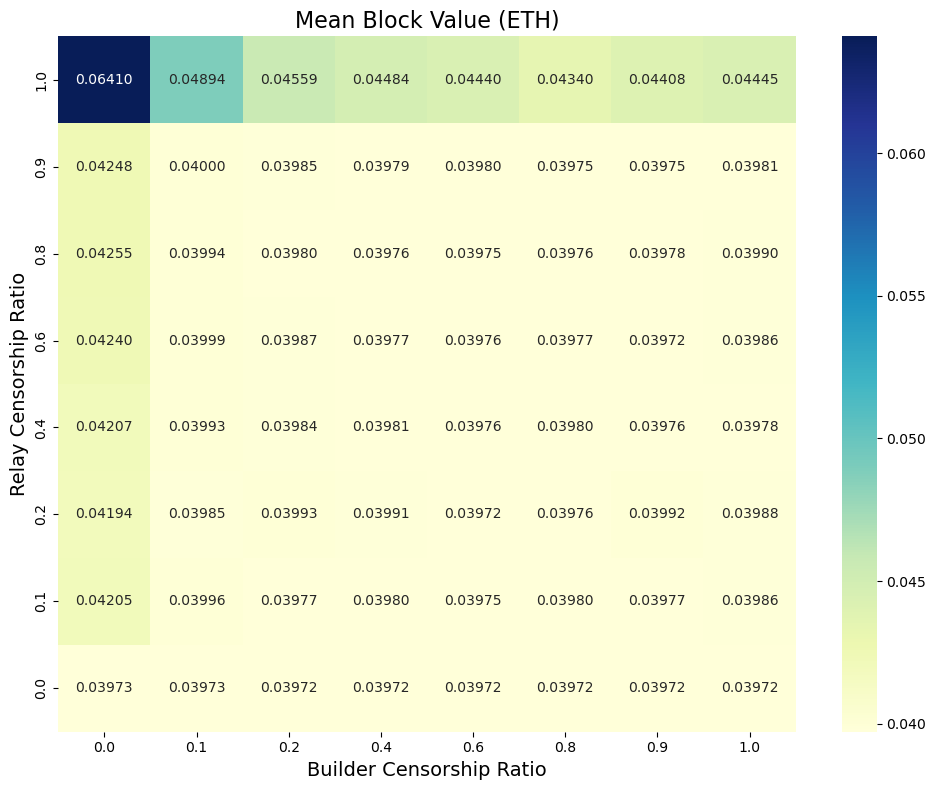

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_censorship_ratio_20250610_145045"


def extract_builder_relay_ratios(folder_name):
    match = re.search(r"builder_relay_censorship_ratio_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        return float(match.group(1)), float(match.group(2))
    return float('inf'), float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_censorship_ratio_")]
folders.sort(key=extract_builder_relay_ratios)

results = []


for folder in folders:
    builder_ratio, relay_ratio = extract_builder_relay_ratios(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    stats = calculate_block_value_stats(blocks, builder_ratio, relay_ratio)
    results.append(stats)

combined_stats = pd.DataFrame(results)


def plot_heatmap(df, value_col, title, fmt=".5f"):
    pivot_df = df.pivot(index='relay_ratio', columns='builder_ratio', values=value_col)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu")
    plt.xlabel('Builder Censorship Ratio', fontsize=14)
    plt.ylabel('Relay Censorship Ratio', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_heatmap(
    combined_stats,
    'avg_total_block_value_eth',
    'Total Block Value (ETH)'
)


plot_heatmap(
    combined_stats,
    'avg_mean_block_value_eth',
    'Mean Block Value (ETH)'
)


#### Average profit (per block & pre node) for builders under different censorship types  - builder_censorship_ratio & relay_censorship_ratio

In [ ]:

def calculate_builder_profit_by_policy(exp_blocks, experiment_name):
   
    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()

    
    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )

   
    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()

   
    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


    builder_policy  mean_builder_profit_per_block(ETH)  \
0              non                            0.001986   
1           strict                            0.000000   
2             weak                            0.000000   
3              non                            0.002103   
4           strict                            0.000000   
5             weak                            0.000000   
6              non                            0.002097   
7           strict                            0.000000   
8             weak                            0.000000   
9              non                            0.002104   
10          strict                            0.000000   
11            weak                            0.000000   
12             non                            0.002120   
13          strict                            0.000000   
14            weak                            0.000000   
15             non                            0.002128   
16          st

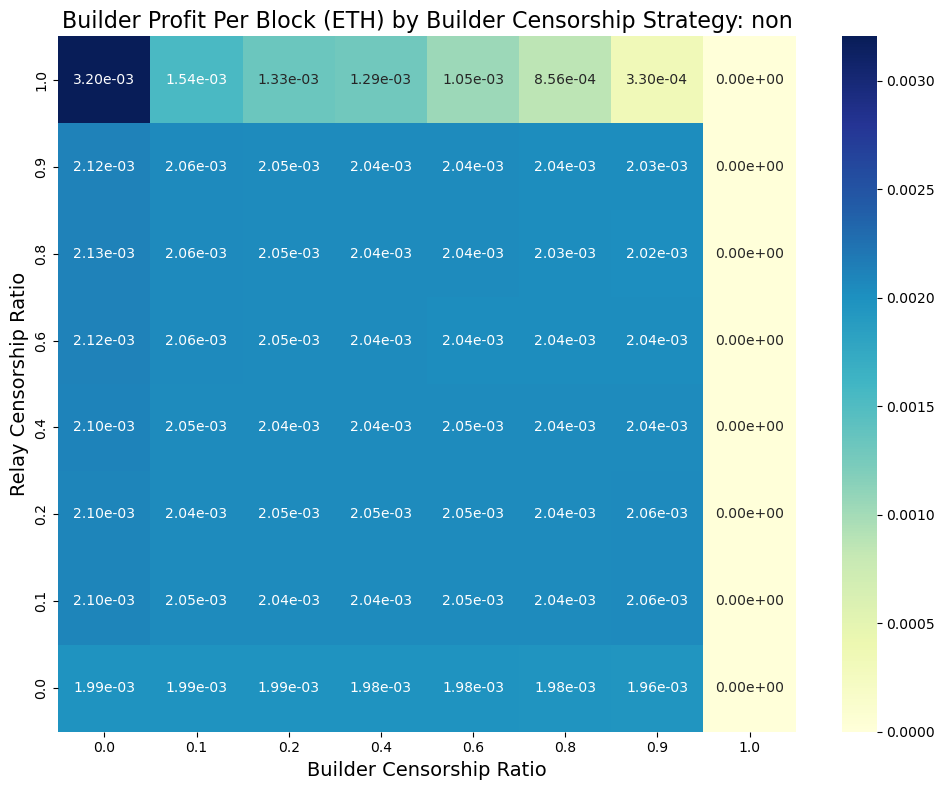

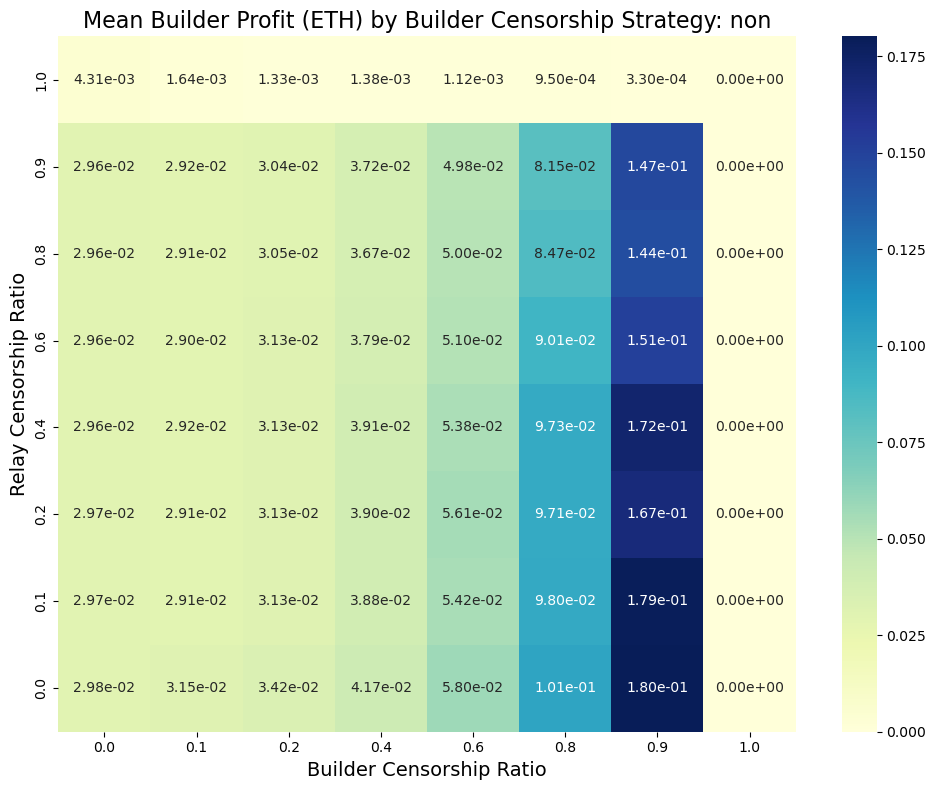

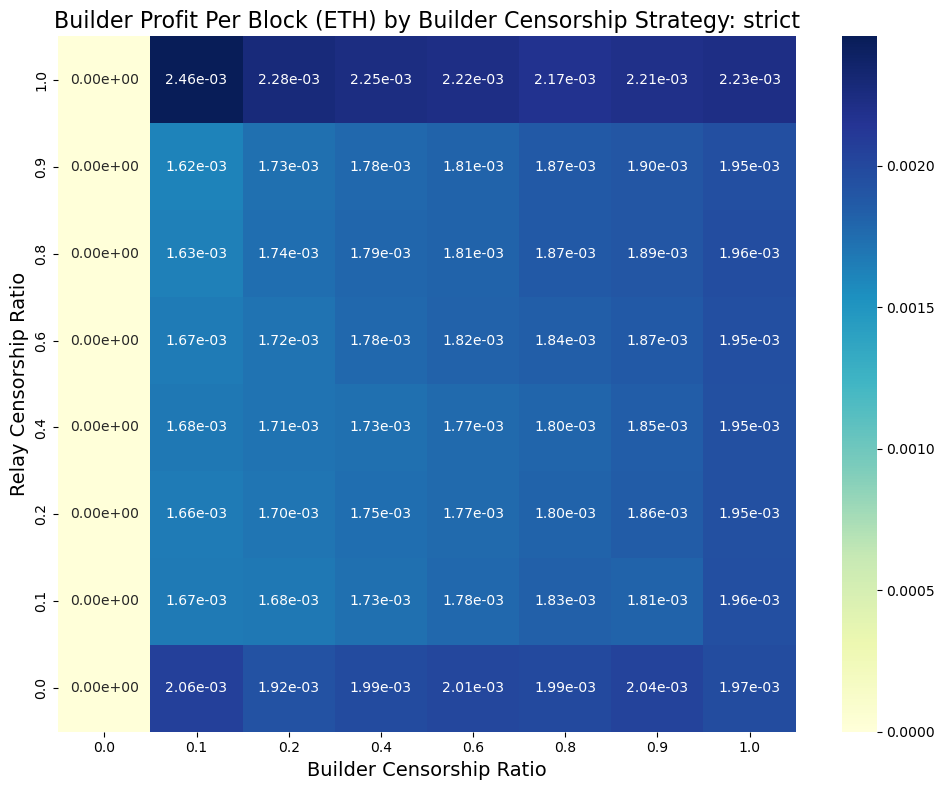

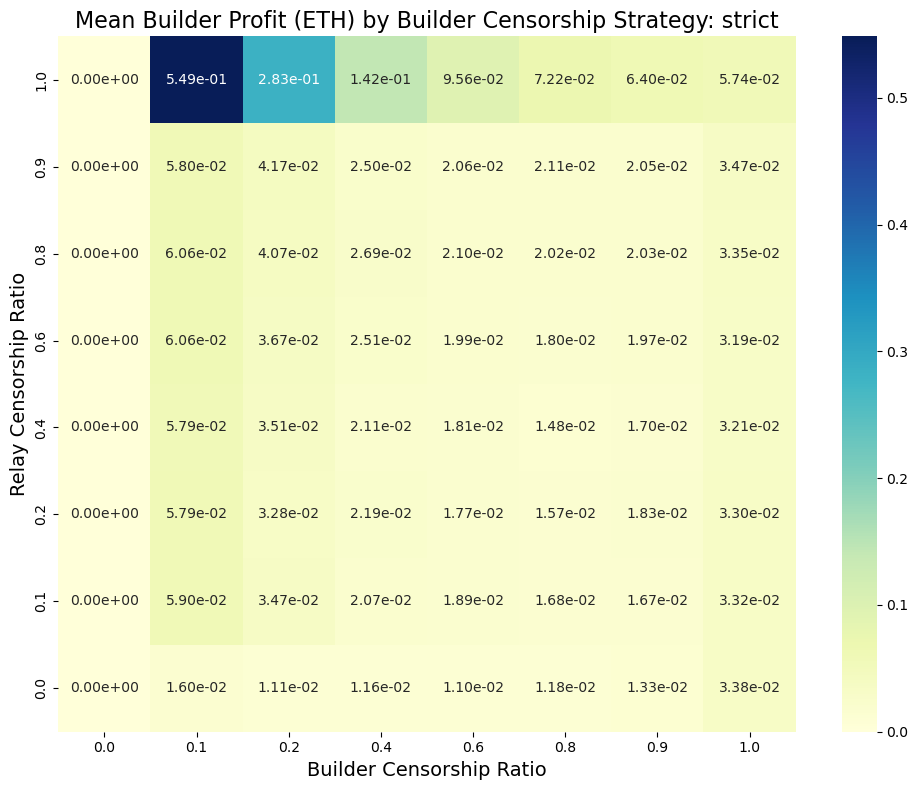

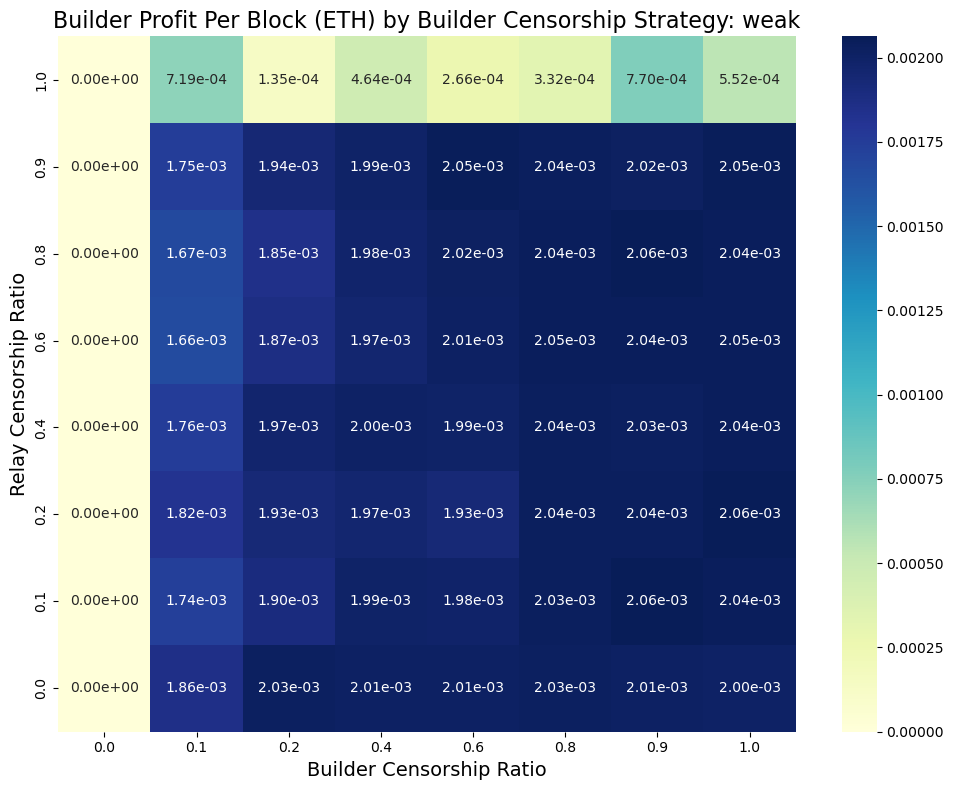

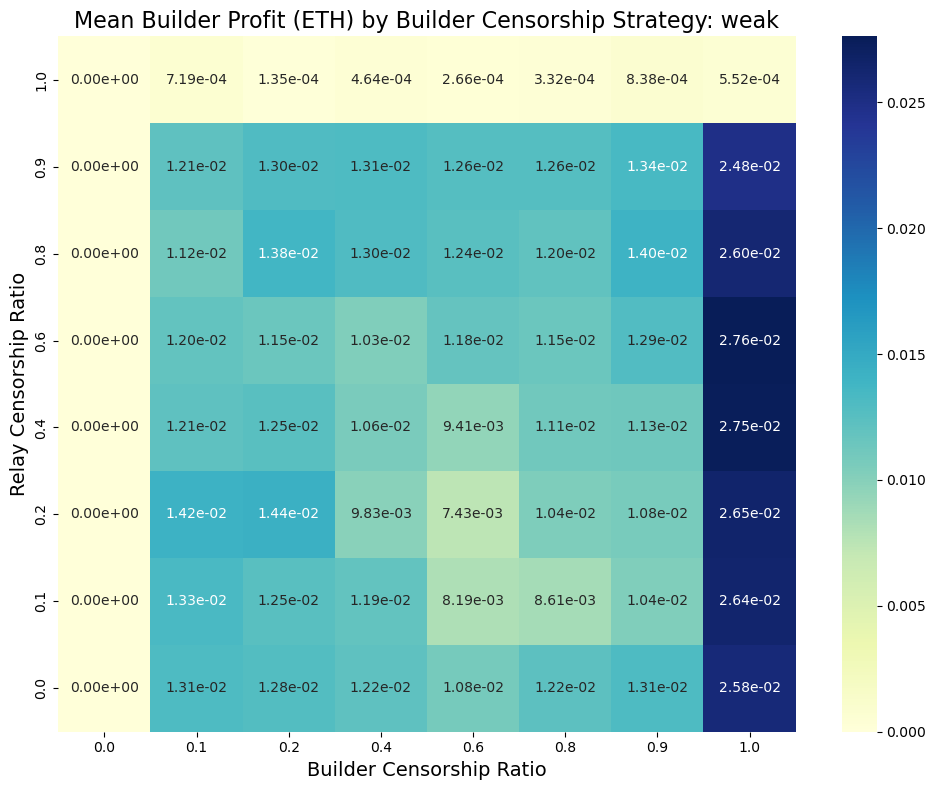

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_censorship_ratio_20250610_145045"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_censorship_ratio_")]


def extract_builder_relay_ratios(folder_name):
    match = re.search(r"builder_relay_censorship_ratio_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        builder_ratio = float(match.group(1))
        relay_ratio = float(match.group(2))
        return (builder_ratio, relay_ratio)
    else:
        return (float('inf'), float('inf'))

folders.sort(key=extract_builder_relay_ratios)

results = []


for folder in folders:
    builder_ratio, relay_ratio = extract_builder_relay_ratios(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

  
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

  
    experiment_label = f'bcr_{builder_ratio:.1f}_rcr_{relay_ratio:.1f}'
    stats = calculate_builder_profit_by_policy(blocks, experiment_label)
    stats['builder_ratio'] = builder_ratio
    stats['relay_ratio'] = relay_ratio
    results.append(stats)


combined_stats = pd.concat(results, ignore_index=True)


print(combined_stats.sort_values(['builder_ratio', 'relay_ratio', 'builder_policy']))



def plot_heatmap(df, policy, value_col, title, fmt=".2e"):
    pivot_df = df[df['builder_policy'] == policy].pivot(
        index='relay_ratio', columns='builder_ratio', values=value_col)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu")
    plt.xlabel('Builder Censorship Ratio', fontsize=14)
    plt.ylabel('Relay Censorship Ratio', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()


policies = combined_stats['builder_policy'].unique()

for policy in policies:
    
    plot_heatmap(
        combined_stats, policy, 'mean_builder_profit_per_block(ETH)',
        f'Builder Profit Per Block (ETH) by Builder Censorship Strategy: {policy}'
    )

    
    plot_heatmap(
        combined_stats, policy, 'mean_builder_profit_per_builder(ETH)',
        f'Mean Builder Profit (ETH) by Builder Censorship Strategy: {policy}'
    )


#### Average profit (per block & pre node) for validators under different censorship types  - builder_censorship_ratio & relay_censorship_ratio

In [53]:
def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]

     proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                              False                              0.037750   
1                               True                              0.037687   
2                              False                              0.041208   
3                               True                              0.032458   
4                              False                              0.041082   
5                               True                              0.032532   
6                              False                              0.041213   
7                               True                              0.032476   
8                              False                              0.041367   
9                               True                              0.033271   
10                             False                              0.041526   
11                              True                            

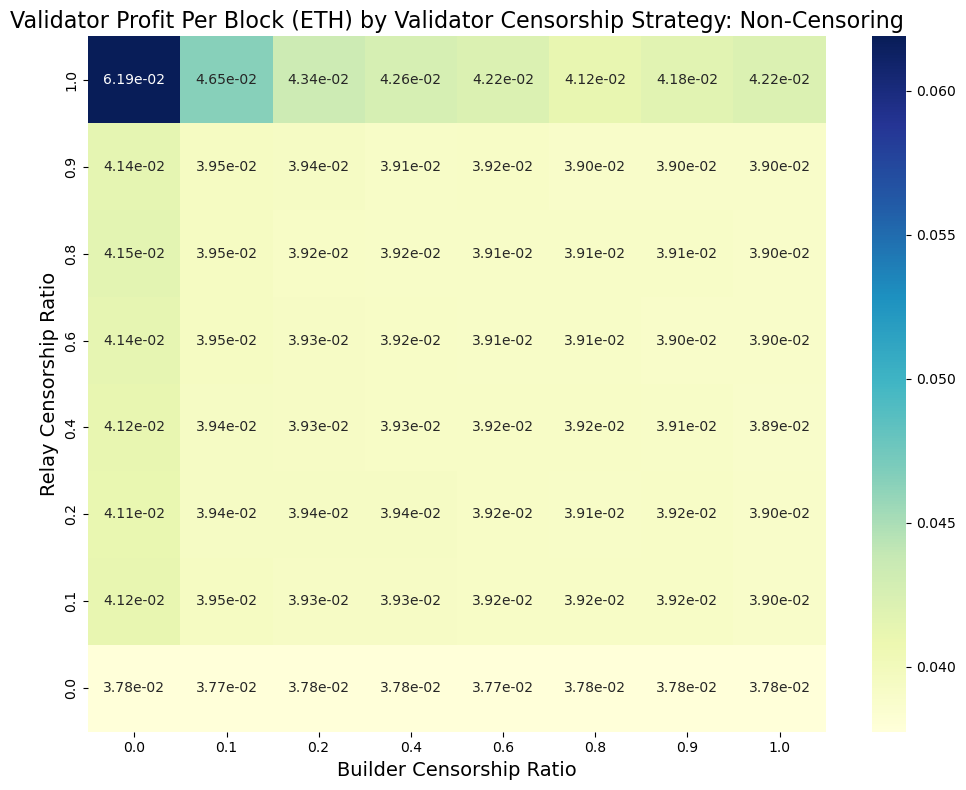

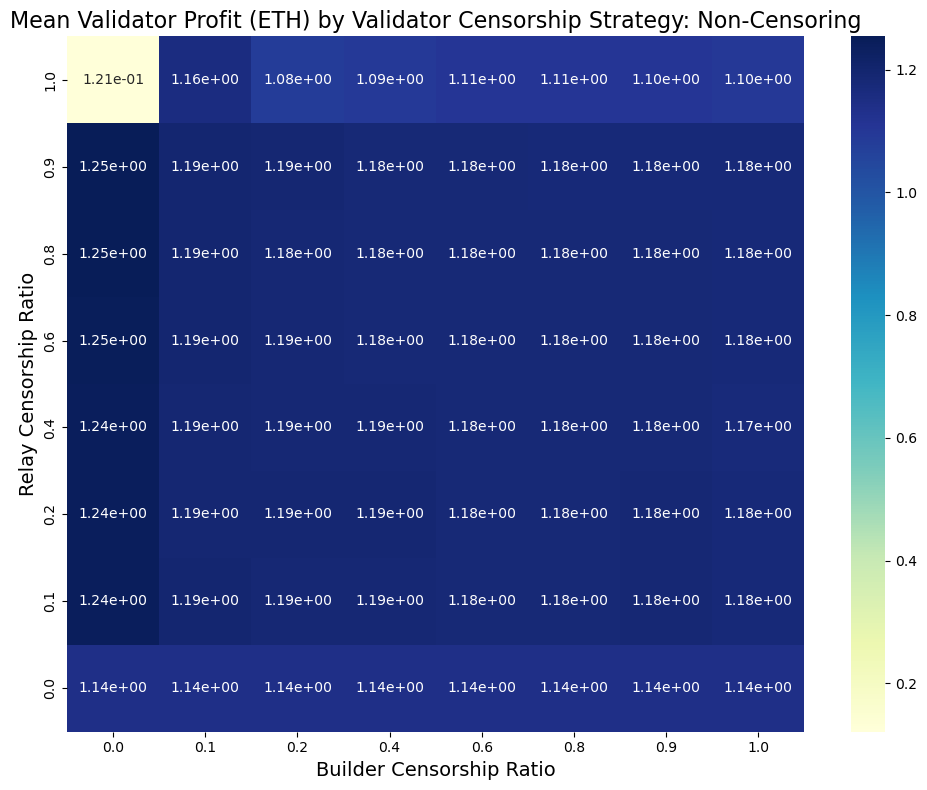

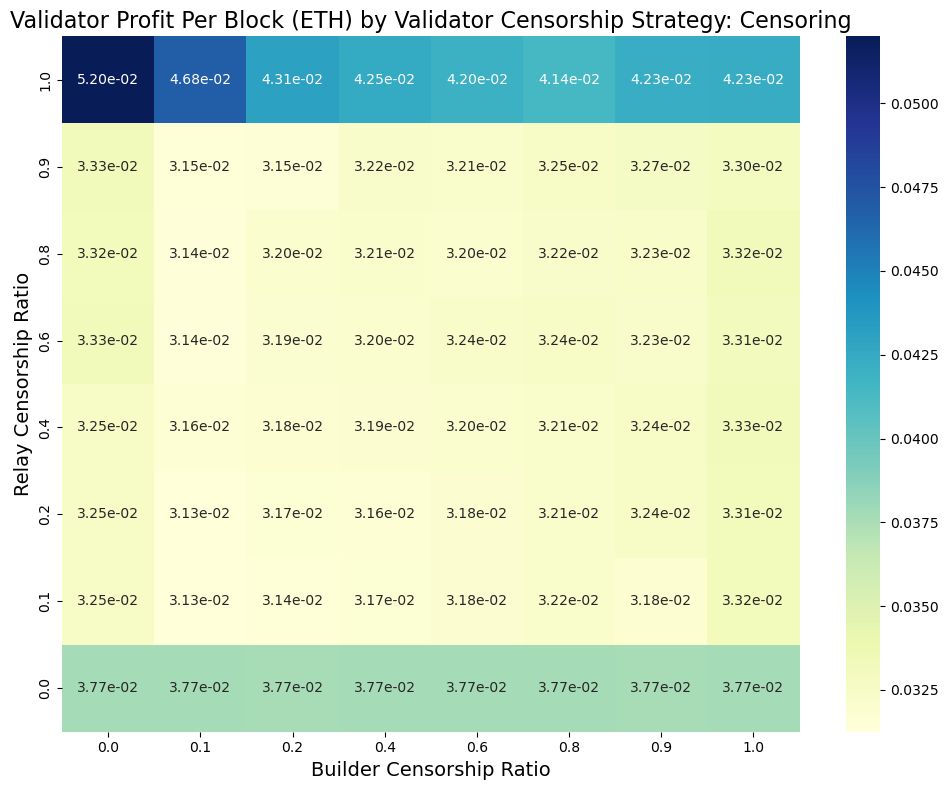

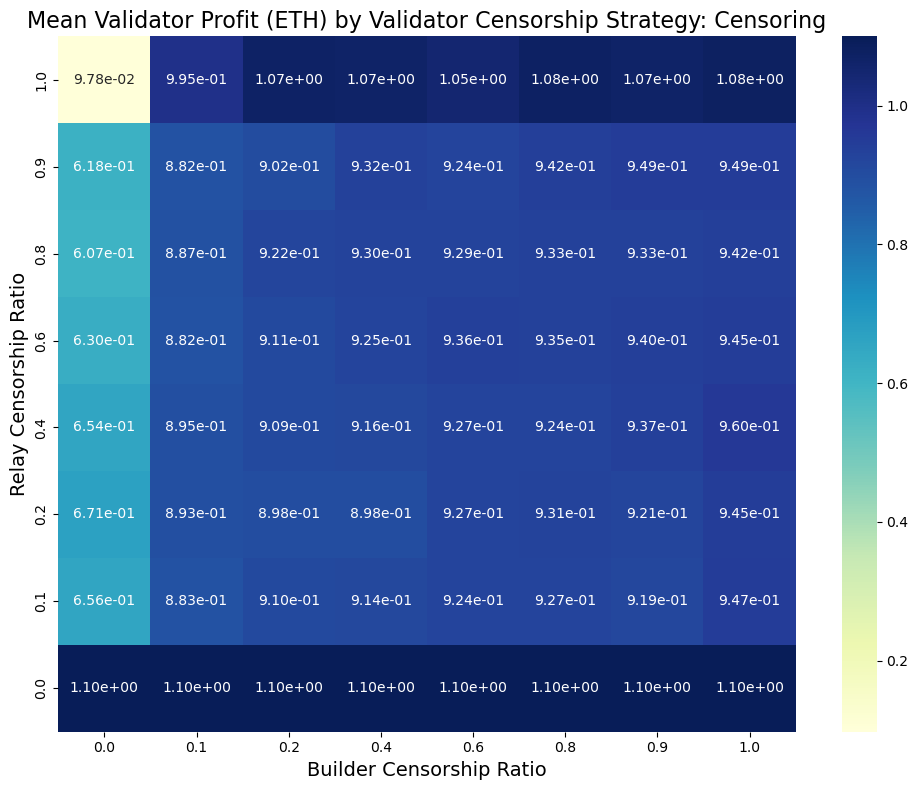

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_builder_relay_censorship_ratio_20250610_145045"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_relay_censorship_ratio_")]


def extract_builder_relay_ratios(folder_name):
    match = re.search(r"builder_relay_censorship_ratio_(\d+\.\d+)_(\d+\.\d+)_", folder_name)
    if match:
        builder_ratio = float(match.group(1))
        relay_ratio = float(match.group(2))
        return (builder_ratio, relay_ratio)
    else:
        return (float('inf'), float('inf'))

folders.sort(key=extract_builder_relay_ratios)

results = []


for folder in folders:
    builder_ratio, relay_ratio = extract_builder_relay_ratios(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

 
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()


    experiment_label = f'bcr_{builder_ratio:.1f}_rcr_{relay_ratio:.1f}'
    stats = calculate_validator_profit_by_policy(blocks, experiment_label)
    stats['builder_ratio'] = builder_ratio
    stats['relay_ratio'] = relay_ratio
    results.append(stats)


combined_stats = pd.concat(results, ignore_index=True)


print(combined_stats.sort_values(['builder_ratio', 'relay_ratio', 'proposer_validator_is_censoring']))



def plot_validator_heatmap(df, is_censoring, value_col, title, fmt=".2e"):
    pivot_df = df[df['proposer_validator_is_censoring'] == is_censoring].pivot(
        index='relay_ratio', columns='builder_ratio', values=value_col)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu")
    plt.xlabel('Builder Censorship Ratio', fontsize=14)
    plt.ylabel('Relay Censorship Ratio', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()


policies = combined_stats['proposer_validator_is_censoring'].unique()

for policy in policies:
    policy_label = 'Censoring' if policy else 'Non-Censoring'


    plot_validator_heatmap(
        combined_stats, policy, 'mean_validator_profit_per_block(ETH)',
        f'Validator Profit Per Block (ETH) by Validator Censorship Strategy: {policy_label}'
    )


    plot_validator_heatmap(
        combined_stats, policy, 'mean_validator_profit_per_validator(ETH)',
        f'Mean Validator Profit (ETH) by Validator Censorship Strategy: {policy_label}'
    )
